In [14]:
# =====================================
# Block 0 — Imports & lightweight setup
# What it does:
#   • Imports everything used later (models, CV, metrics, plotting)
#   • Sets display options and silences noisy warnings
#   • Prepares a small cache directory for speed
# =====================================
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display

# Core sklearn plumbing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Splits/CV/search
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, RandomizedSearchCV

# Metrics
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, classification_report

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
try:
    from lightgbm import LGBMClassifier
    HAS_LGBM = True
except Exception:
    HAS_LGBM = False

# Search spaces + caching
from scipy.stats import randint, loguniform, uniform
from joblib import Memory

# General setup
np.random.seed(42)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)
memory = Memory(location='cache_joblib', verbose=0)


In [15]:
# =====================================
# Block 0.1 — Load data (robust path)
# What it does:
#   • Loads your CSV (works with Windows path, CWD, or /mnt/data)
#   • Prints shape, preview, and duplicate-row count
#   • Do your existing cleaning next to create `df`
# =====================================
CSV_PATHS = [
    r"C:\Users\Youssef\Downloads\final_extraction_mimic 2.csv",  # your local path
                    
]

data = None
for p in CSV_PATHS:
    try:
        data = pd.read_csv(p, low_memory=False)
        print(f"[Block 0.1] Loaded: {p}")
        break
    except Exception:
        pass

if data is None:
    raise FileNotFoundError("Could not load dataset from known paths in CSV_PATHS.")

print(f"[Block 0.1] Shape: {data.shape}")
display(data.head(3))
dup_count = data.duplicated().sum()
print(f"[Block 0.1] Duplicate rows (count only): {dup_count}")

# >>> If you already have cleaning/selection code that builds `df`, run it here and SKIP Block 0.2 <<<


[Block 0.1] Loaded: C:\Users\Youssef\Downloads\final_extraction_mimic 2.csv
[Block 0.1] Shape: (139645, 132)


,hadm_id,subject_id,first_admittime,admittime,dischtime,age,Sex,race,chads2_score,BMI (kg/m2),sleep_apnea,Diastolic BP,Systolic BP,dementia,Previous stroke,cerebral_hemorrhage,Stroke_TIA,neuropathy,parkinsons,somatoform_disorder,prior_bleeding,systemic_embolism,myocardial_infarction,Coronary_Artery_Disease,acs,lvh,thromboembolism,Venous_Thromboembolism,angina,Peripheral_Artery_Disease,atherosclerosis,pvd,pe,valvular_disease,hypothyroidism,hypotension,hyperthyroidism,Hypertension,Cardiomyopathy,other_cvd,copd,infection,inflammatory_disease,allergy,hyperplasia_of_prostate,Chronic_Kidney_Disease,renal_failure,renal_insufficiency,incontinence,ureter_stones,gall_pancreatic_disorders,gynecological,peptic_ulcer,hemorrhoids,liver_disease,diverticulitis,gastritis,lipid_disorder,hypercholesterolemia,anemia,thrombocytopenia,osteoporosis,dorsopathies,gout,arthritis,psoriasis,Chemistry_Albumin,"Chemistry_Albumin, Ascites","Chemistry_Albumin, Pleural","Chemistry_Albumin, Body Fluid",Chemistry_Alkaline Phosphatase,Chemistry_Creatinine Clearance,Blood Gas_Estimated GFR (MDRD equation),Hematology_Hemoglobin,Chemistry_Troponin T,Chemistry_Homocysteine,Chemistry_Testosterone,Hematology_Bilirubin Crystals,Blood Gas_Hemoglobin,Hematology_Sedimentation Rate,Hematology_Hemoglobin A2,Hematology_Hemoglobin C,Hematology_Hemoglobin F,"Hematology_Lymphocytes, Percent",Hematology_Platelet Smear,Hematology_Platelet Clumps,Hematology_Red Blood Cells,Hematology_Leukocytes,CHADS_VASc,CHADS_VA,had_valve_surgery,had_cardiac_surgery,had_blood_transfusion,had_stent_impl,had_cabg,had_ablation,had_dc_cardioversion,had_mechanical_ventilation,Mort_365,Rehosp_365days,"Chemistry_Albumin, Urine_g_per_dL",Chemistry_Urea Nitrogen_g_per_dL,"Chemistry_Urea Nitrogen, Urine_g_per_dL","Chemistry_Urea Nitrogen, Body Fluid_g_per_dL","Chemistry_Cholesterol, Total_g_per_dL","Chemistry_Cholesterol, Pleural_g_per_dL",Chemistry_Glucose_g_per_dL,"Chemistry_Glucose, Urine_g_per_dL","Chemistry_Glucose, Body Fluid_g_per_dL","Chemistry_Glucose, Ascites_g_per_dL","Chemistry_Glucose, Pleural_g_per_dL","Chemistry_Glucose, CSF_g_per_dL","Chemistry_Glucose, Joint Fluid_g_per_dL",Hematology_Glucose_g_per_dL,Blood Gas_Glucose_g_per_dL,"Hematology_Fibrinogen, Functional_g_per_dL","Chemistry_Cholesterol, HDL_g_per_dL","Chemistry_Cholesterol, LDL, Calculated_g_per_dL","Chemistry_Cholesterol, LDL, Measured_g_per_dL","Chemistry_Testosterone, Free_ng_per_mL","Chemistry_Bilirubin, Total_g_per_dL","Chemistry_Bilirubin, Total, Ascites_g_per_dL","Chemistry_Bilirubin, Total, Body Fluid_g_per_dL","Chemistry_Bilirubin, Total, Pleural_g_per_dL",Chemistry_Triglycerides_g_per_dL,"Chemistry_Triglycerides, Ascites_g_per_dL","Chemistry_Triglycerides, Pleural_g_per_dL",Chemistry_Uric Acid_g_per_dL,"Chemistry_Uric Acid, Urine_g_per_dL",Hematology_Ketone_g_per_dL,Hematology_Absolute Lymphocyte Count__per_uL,Hematology_Platelet Count__per_uL
0,22595853,10000032,06/05/2180 22:23,06/05/2180 22:23,07/05/2180 17:15,52,0,WHITE,0,18.0,False,65.0,110.0,0.0,False,0.0,0,0.0,0.0,0.0,False,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,False,0.0,False,False,0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,103.0,NaN,NaN,12.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.80,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,0.02500,NaN,NaN,NaN,NaN,0.09900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71000.0
1,25022803,10000068,03/03/2160 23:16,03/03/2160 23:16,04/03/2160 06:26,19,0,WHITE,0,NaN,False,NaN,NaN,0.0,False,0.0,0,0.0,0.0,0.0,False,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,0.0,0.0,False,0.0,False,False,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

[Block 0.1] Duplicate rows (count only): 0


In [16]:
# =====================================
# Block 0.2 — Build `df` if it doesn't exist yet
# What it does:
#   • Creates df from your loaded `data`
#   • Uses your `allowed_columns` if present, else keeps all columns
#   • Verifies the target column exists
# =====================================
TARGET = 'Rehosp_365days'

if 'df' not in globals():
    if 'allowed_columns' in globals():
        existing_columns = [c for c in allowed_columns if c in data.columns]
        df = data[existing_columns].copy()
        print(f"[Block 0.2] Created df from allowed_columns. Shape={df.shape}")
    else:
        df = data.copy()
        print(f"[Block 0.2] Created df as full copy of data. Shape={df.shape}")

assert TARGET in df.columns, f"[Block 0.2] Target '{TARGET}' not found in df.columns."


DataFrame Shape: (139645, 132)

Column Types:
float64    106
int64       15
bool         7
object       4
Name: count, dtype: int64

First 5 rows:
    hadm_id  subject_id   first_admittime         admittime         dischtime  age  Sex   race  chads2_score  BMI (kg/m2)  sleep_apnea  \
0  22595853    10000032  06/05/2180 22:23  06/05/2180 22:23  07/05/2180 17:15   52    0  WHITE             0    18.000000        False   
1  25022803    10000068  03/03/2160 23:16  03/03/2160 23:16  04/03/2160 06:26   19    0  WHITE             0          NaN        False   
2  23052089    10000084  21/11/2160 01:56  21/11/2160 01:56  25/11/2160 14:52   72    1  WHITE             0    24.400000        False   
3  27250926    10000108  27/09/2163 23:17  27/09/2163 23:17  28/09/2163 09:04   25    1  WHITE             0          NaN        False   
4  22927623    10000117  15/11/2181 02:05  15/11/2181 02:05  15/11/2181 14:52   55    0  WHITE             0    18.958333        False   

   Diastolic BP  Systoli

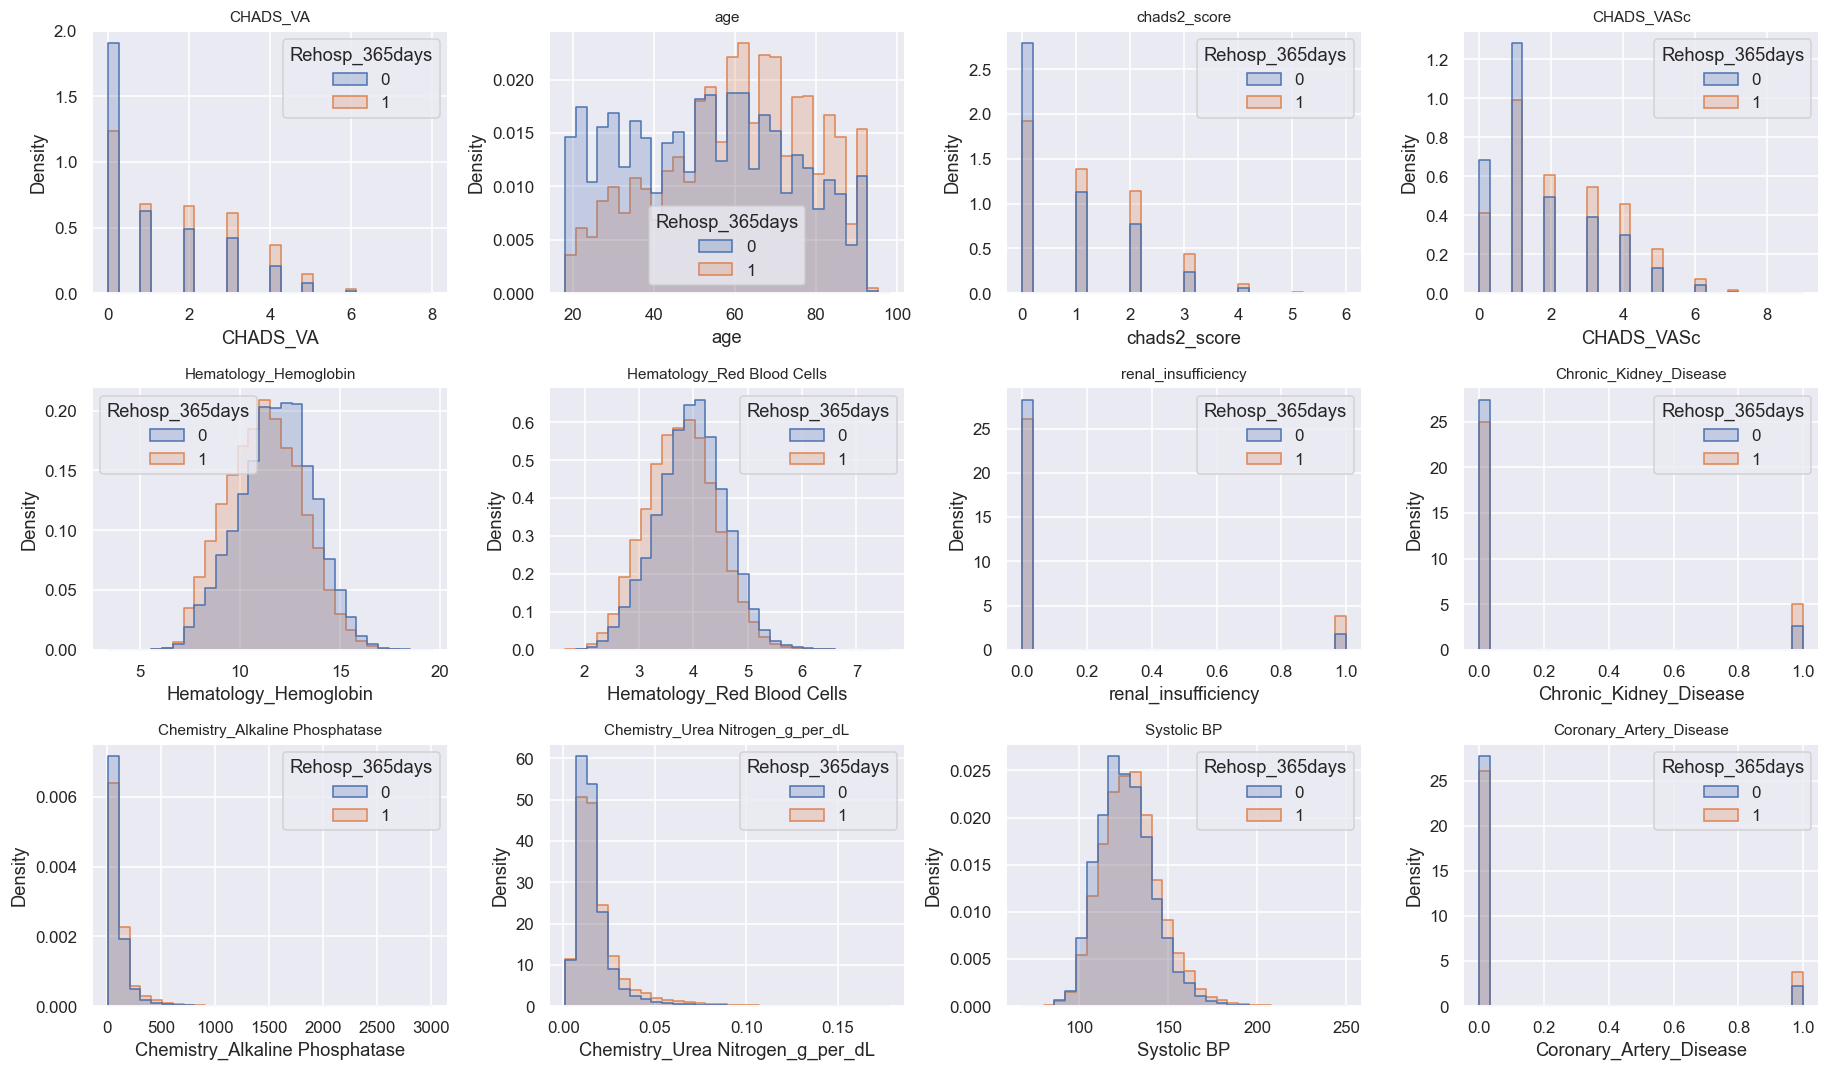

In [17]:
# =====================================
# Block 0.3 — Lean, targeted EDA for Rehosp_365days
# What it does:
#   • Prints shape/dtypes/head + top-20 missingness table
#   • Shows target distribution
#   • Plots TOP-K numeric features by |Spearman corr| with target (overlaid by class)
#   • Plots TOP-K low-cardinality categoricals by deviation in readmission rate
#   • Shows a compact correlation heatmap for the selected numerics
# =====================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
sns.set()

assert 'df' in globals(), "Build df in Block 0.2 first."
TARGET = 'Rehosp_365days'
assert TARGET in df.columns, f"Target '{TARGET}' not found in df."

# ---- knobs (tweak as you like) ----
TOP_NUM = 12          # number of numeric features to plot
TOP_CAT = 6           # number of categorical features to plot
MISS_CAP = 0.80       # ignore features with >80% missing for scoring
LOW_CARD_MAX = 10     # only consider categoricals with ≤ this many levels
IGNORE_COLS = set(['Mort_365','first_admittime','admittime','dischtime','hadm_id','subject_id'])

# ---- basic snapshot ----
print("DataFrame Shape:", df.shape)
print("\nColumn Types:")
print(df.dtypes.value_counts())
print("\nFirst 5 rows:")
print(df.head())

print("\nTop 20 columns by missingness:")
missing_pct = df.isnull().mean().sort_values(ascending=False)
print((missing_pct.head(20) * 100).round(1).astype(str) + "%")

# ---- target distribution ----
print("\nTarget distribution (counts & %) — Rehosp_365days:")
print(df[TARGET].value_counts(dropna=False))
print((df[TARGET].value_counts(normalize=True) * 100).round(1).astype(str) + "%")

# ---- select columns for scoring ----
num_cols_all = df.select_dtypes(include=[np.number]).columns.tolist()
# keep numerics except target & ignores & heavy-missing
num_cols = [c for c in num_cols_all
            if c not in IGNORE_COLS and c != TARGET and (1 - df[c].isna().mean()) >= (1 - MISS_CAP)]
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in IGNORE_COLS]

# ---- top numerics by |Spearman correlation| with target ----
spearman_scores = []
for c in num_cols:
    tmp = df[[c, TARGET]].dropna()
    if tmp[c].nunique() > 1 and len(tmp) > 50:  # small guard
        cor = tmp.corr(method='spearman').iloc[0,1]
        if pd.notnull(cor):
            spearman_scores.append((c, abs(cor)))
top_num = [c for c,_ in sorted(spearman_scores, key=lambda x: x[1], reverse=True)[:TOP_NUM]]

# ---- class-conditional histograms for top numerics ----
if top_num:
    ncols = 4
    nrows = int(np.ceil(len(top_num) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.2*ncols, 3.3*nrows), dpi=110)
    axes = np.atleast_1d(axes).ravel()
    for i, col in enumerate(top_num):
        sns.histplot(data=df, x=col, hue=TARGET, stat='density',
                     bins=30, common_norm=False, element='step', ax=axes[i])
        axes[i].set_title(col, fontsize=10)
    for j in range(i+1, len(axes)):
        axes[j].axis('off')
    plt.tight_layout(); plt.show()









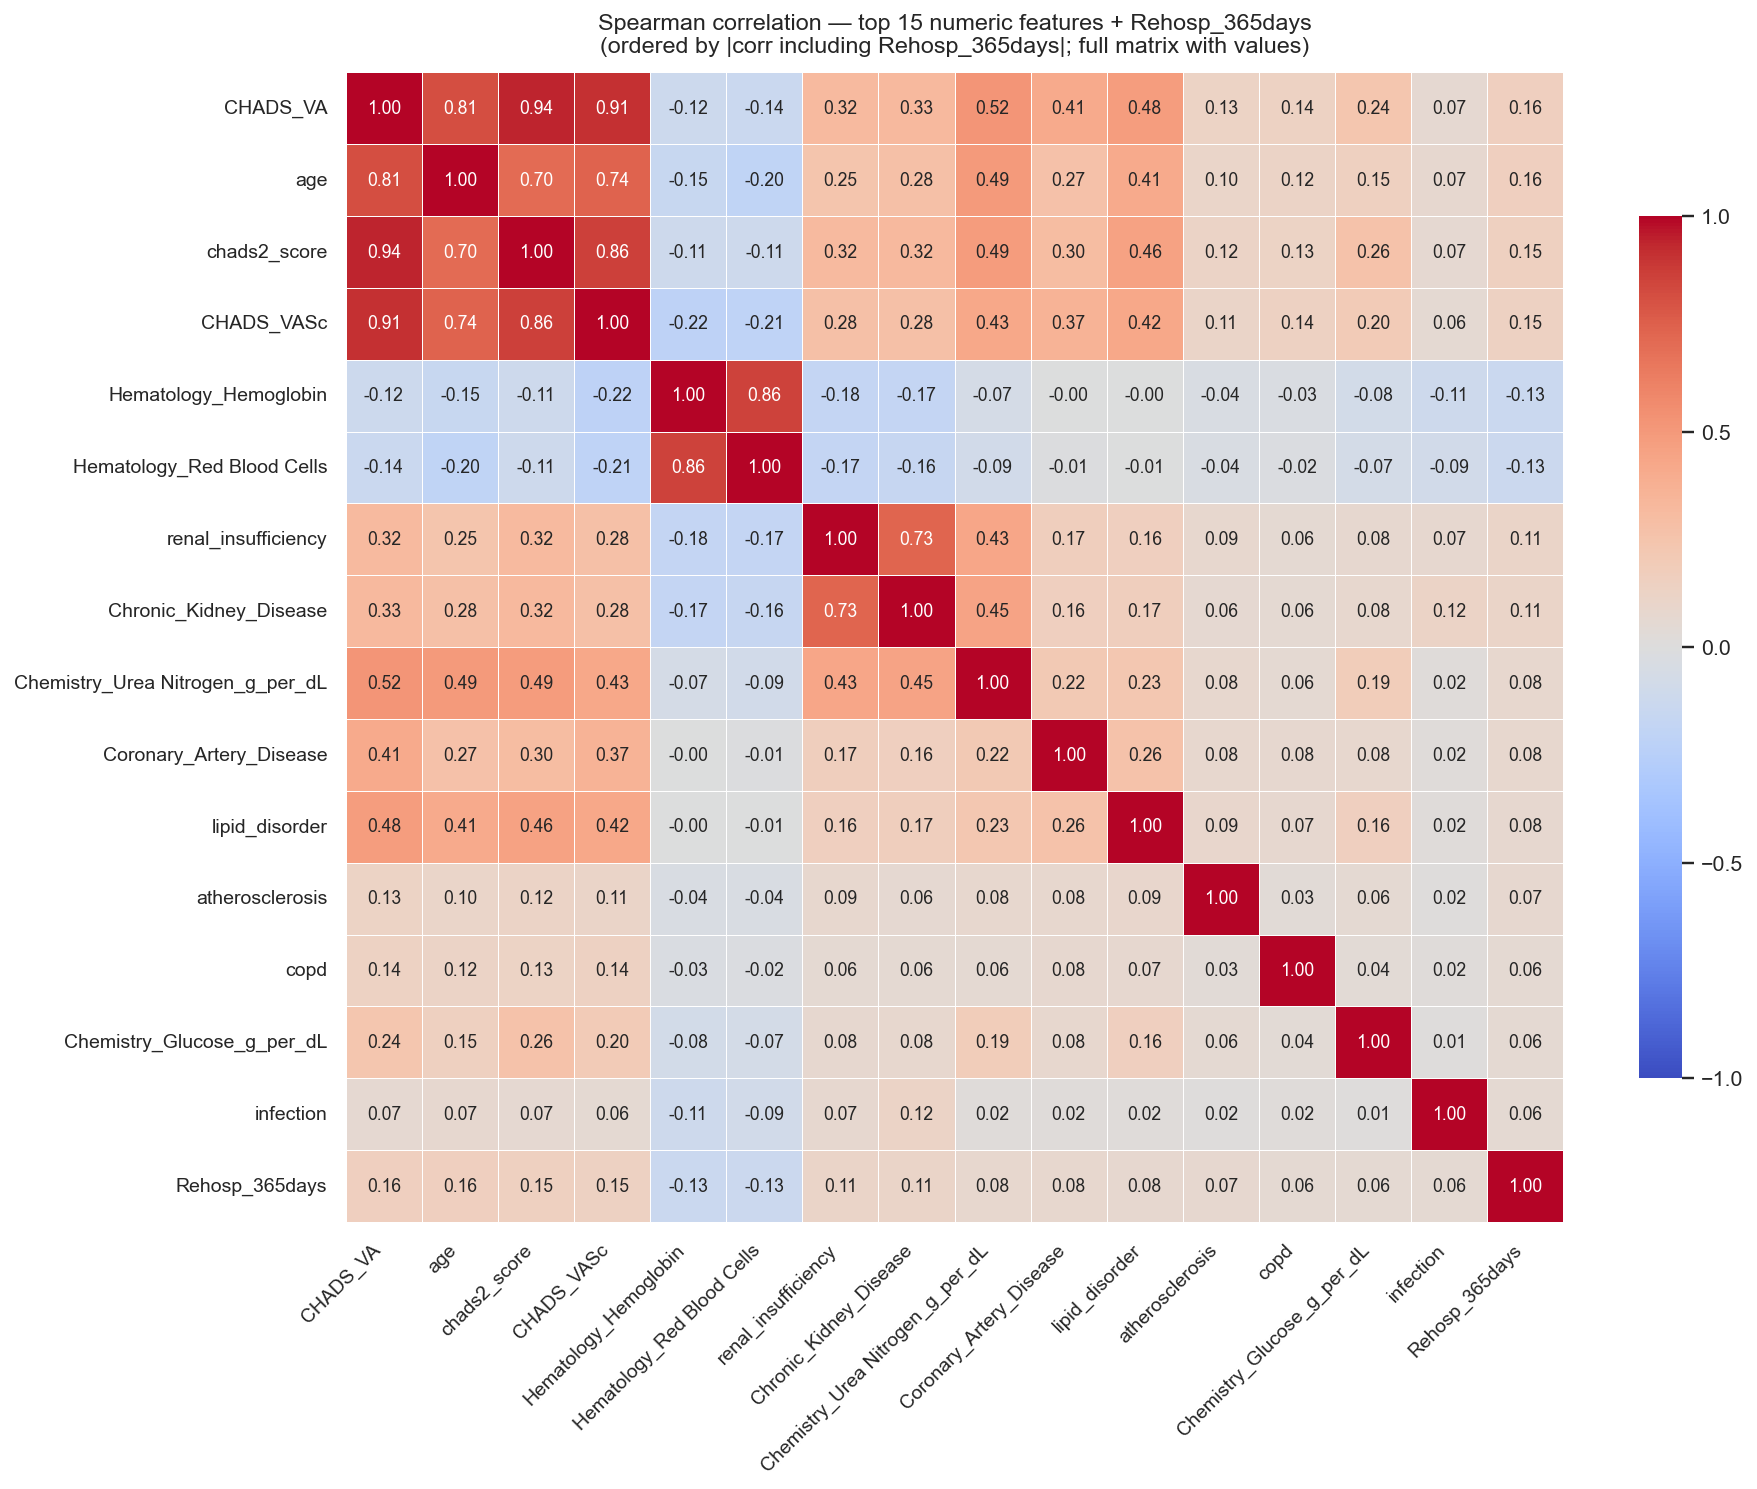


|Correlation| with target:
CHADS_VA                            0.158974
age                                 0.157725
chads2_score                        0.149423
CHADS_VASc                          0.145835
Hematology_Hemoglobin               0.134285
Hematology_Red Blood Cells          0.127505
renal_insufficiency                 0.112353
Chronic_Kidney_Disease              0.111974
Chemistry_Urea Nitrogen_g_per_dL    0.081741
Coronary_Artery_Disease             0.078452
lipid_disorder                      0.077012
atherosclerosis                     0.070375
copd                                0.062233
Chemistry_Glucose_g_per_dL          0.061617
infection                           0.060822


In [18]:
# ============================================
# Block CM1 — Correlation matrix incl. target (TOP 15, full matrix, all numbers)
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# --- knobs ---
TOP_N        = 15      # <- keep only the top 15 numeric features
MIN_COVERAGE = 0.40
IGNORE       = {'hadm_id','subject_id','first_admittime','admittime','dischtime','Mort_365'}
METHOD       = 'spearman'   # or 'pearson'

# --- pick target (356 fallback) ---
if 'Rehosp_356days' in df.columns:
    TARGET = 'Rehosp_356days'
elif 'Rehosp_365days' in df.columns:
    TARGET = 'Rehosp_365days'
else:
    raise ValueError("Target not found: expected 'Rehosp_356days' or 'Rehosp_365days'.")

# --- ensure numeric target (0/1) ---
_df = df.copy()
if not pd.api.types.is_numeric_dtype(_df[TARGET]):
    _df[TARGET] = pd.Categorical(_df[TARGET]).codes

# --- numeric features with enough data ---
num_cols = [c for c in _df.select_dtypes(include=[np.number]).columns
            if c not in IGNORE and _df[c].notna().mean() >= MIN_COVERAGE]
if TARGET not in num_cols:
    num_cols.append(TARGET)

# --- correlation & ordering by |corr with target| ---
corr_all = _df[num_cols].corr(method=METHOD)
order = (corr_all[TARGET].drop(TARGET).abs()
         .sort_values(ascending=False).head(TOP_N).index.tolist()) + [TARGET]
corr = corr_all.loc[order, order]

# --- plot full matrix with ALL annotations ---
n = len(order)
fig_w = min(0.6 * n + 4, 22)
fig_h = 0.55 * n + 2
plt.figure(figsize=(fig_w, fig_h), dpi=140)

sns.heatmap(
    corr,
    cmap='coolwarm', vmin=-1, vmax=1, center=0,
    linewidths=0.4, linecolor='white',
    annot=corr.round(2), fmt=".2f",
    annot_kws={'size': 9},
    cbar_kws={'shrink': 0.75, 'ticks': [-1, -0.5, 0, 0.5, 1]}
)

plt.title(
    f"{METHOD.capitalize()} correlation — top {n-1} numeric features + {TARGET}\n"
    f"(ordered by |corr including {TARGET}|; full matrix with values)",
    pad=10
)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

print("\n|Correlation| with target:")
print(corr[TARGET].drop(TARGET).abs().sort_values(ascending=False).to_string())


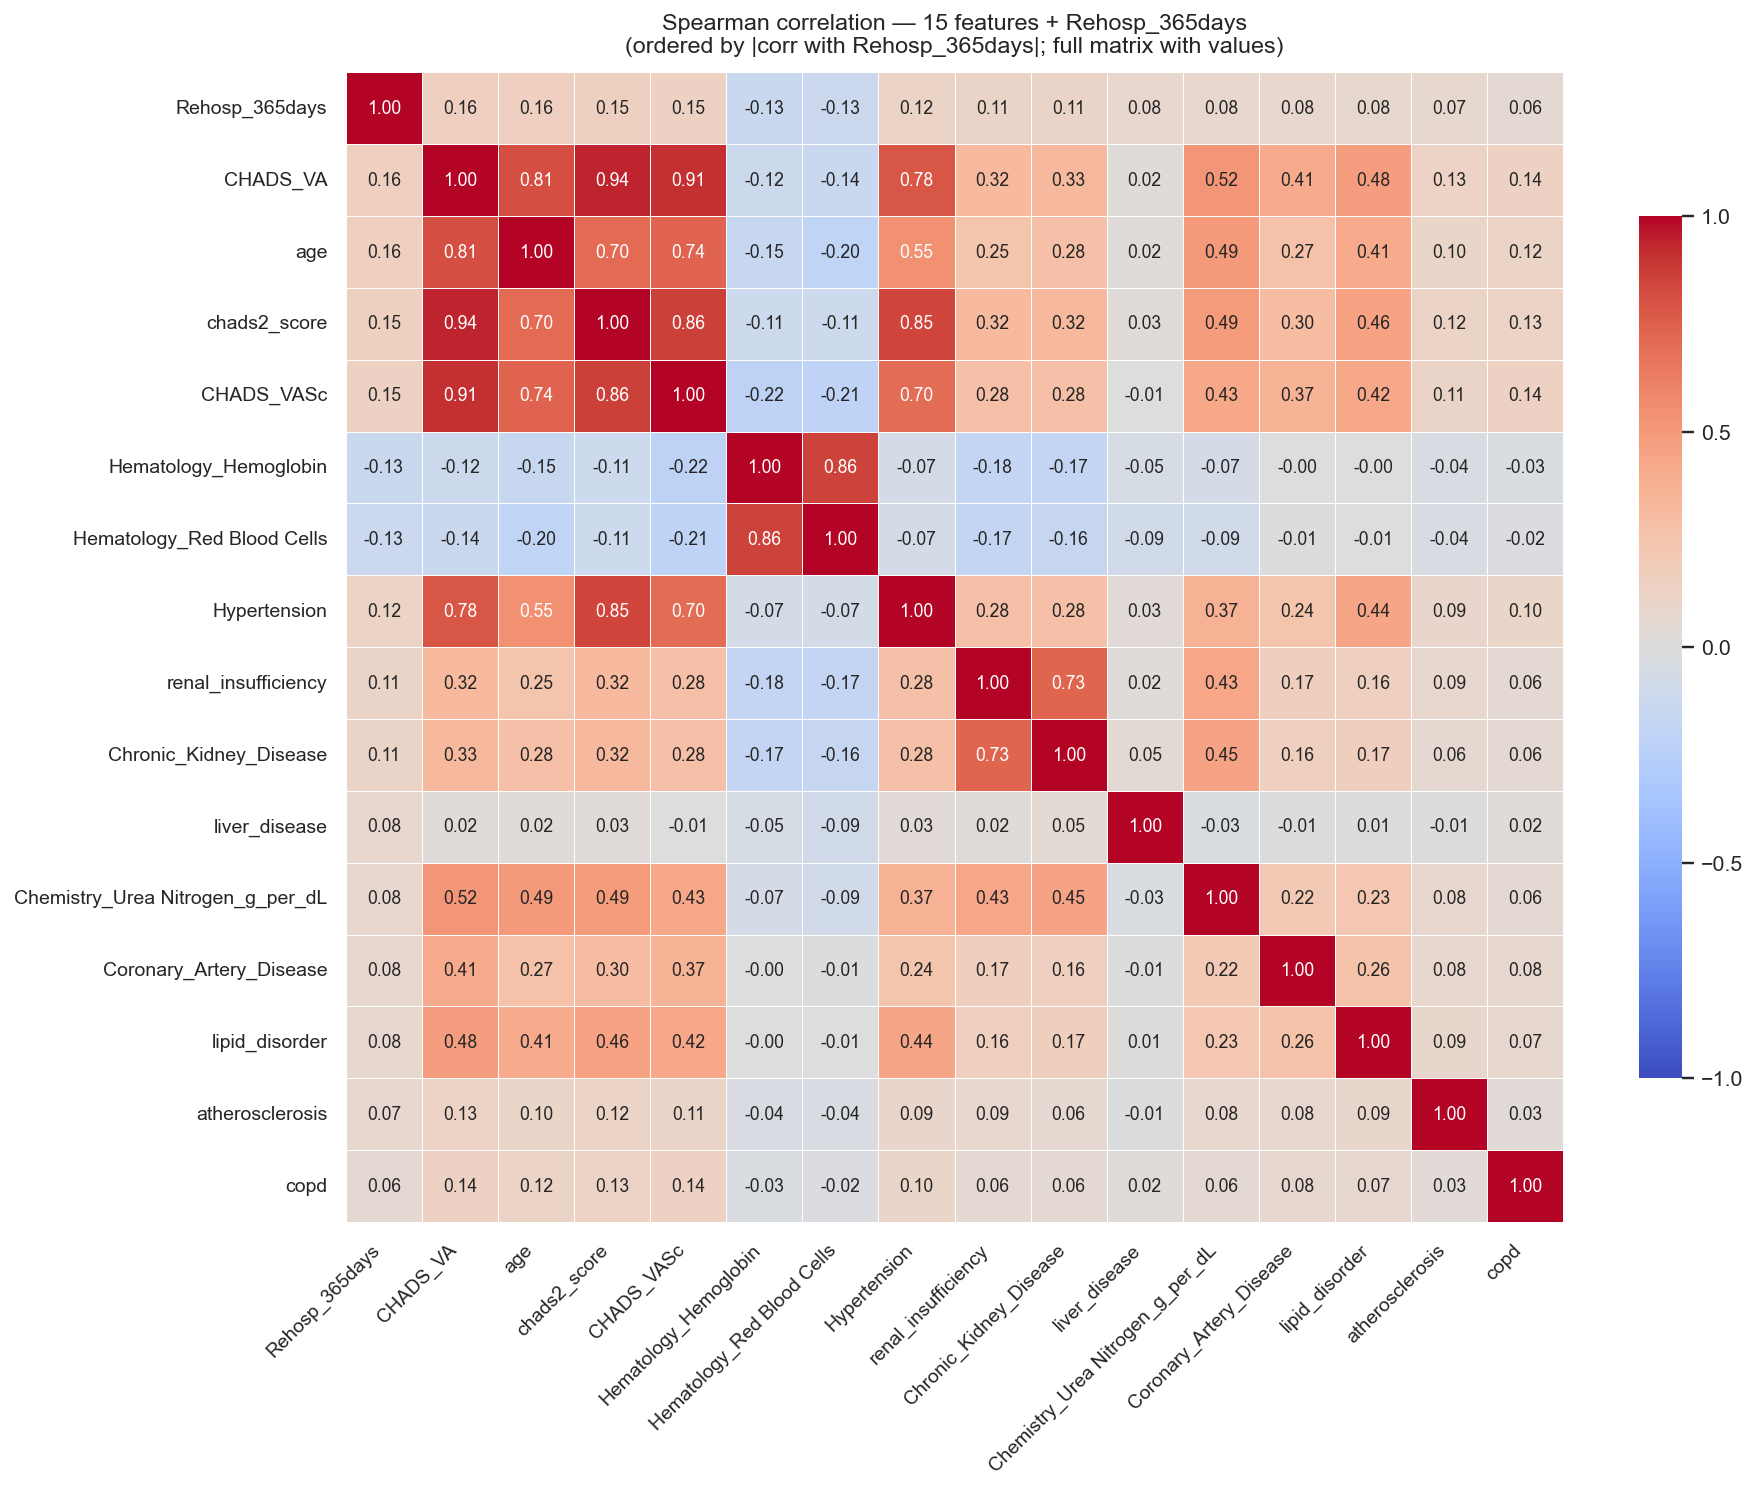


|Correlation| with target:
CHADS_VA                            0.158974
age                                 0.157725
chads2_score                        0.149423
CHADS_VASc                          0.145835
Hematology_Hemoglobin               0.134285
Hematology_Red Blood Cells          0.127505
Hypertension                        0.122174
renal_insufficiency                 0.112353
Chronic_Kidney_Disease              0.111974
liver_disease                       0.083390
Chemistry_Urea Nitrogen_g_per_dL    0.081741
Coronary_Artery_Disease             0.078452
lipid_disorder                      0.077012
atherosclerosis                     0.070375
copd                                0.062233


In [19]:
# ============================================
# Block CM2 — Correlation heatmap for FEATURES + Rehosp_365days
# Use FEATURES to specify columns explicitly; leave empty to auto-pick top K by |corr|
# ============================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

# --- choose your features here (optional) ---
FEATURES = []   # e.g.: ['age','CHADS_VA','Hematology_Hemoglobin', ...]
TOP_K    = 15   # used only when FEATURES == []

# --- settings ---
TARGET        = 'Rehosp_365days'
METHOD        = 'spearman'     # or 'pearson'
MIN_COVERAGE  = 0.40           # drop cols with <40% non-null
IGNORE        = {'hadm_id','subject_id','first_admittime','admittime','dischtime','Mort_365'}

# --- ensure target exists and is numeric ---
assert TARGET in df.columns, f"{TARGET} not found in df"
_df = df.copy()
if not pd.api.types.is_numeric_dtype(_df[TARGET]):
    _df[TARGET] = pd.Categorical(_df[TARGET]).codes

# --- candidate numeric/boolean features with enough data ---
candidates = [c for c in _df.select_dtypes(include=[np.number, 'bool']).columns
              if c != TARGET and c not in IGNORE and _df[c].notna().mean() >= MIN_COVERAGE]

# --- resolve the set to use ---
if FEATURES:
    use = [c for c in FEATURES if c in _df.columns and c in candidates]
else:
    # auto-pick by |corr with target|
    corr_target = _df[candidates + [TARGET]].corr(method=METHOD)[TARGET].drop(TARGET).abs()
    use = corr_target.sort_values(ascending=False).head(TOP_K).index.tolist()

cols = use + [TARGET]

# --- compute and order by |corr with target| ---
corr = _df[cols].corr(method=METHOD)
order = corr[TARGET].abs().sort_values(ascending=False).index.tolist()
corr = corr.loc[order, order]

# --- plot full matrix with ALL annotations ---
n = len(order)
fig_w = min(0.6 * n + 4, 22)
fig_h = 0.55 * n + 2
plt.figure(figsize=(fig_w, fig_h), dpi=140)

sns.heatmap(
    corr,
    cmap='coolwarm', vmin=-1, vmax=1, center=0,
    linewidths=0.4, linecolor='white',
    annot=corr.round(2), fmt=".2f",
    annot_kws={'size': 9},
    cbar_kws={'shrink': 0.75, 'ticks': [-1, -0.5, 0, 0.5, 1]}
)

plt.title(
    f"{METHOD.capitalize()} correlation — {len(use)} features + {TARGET}\n"
    f"(ordered by |corr with {TARGET}|; full matrix with values)",
    pad=10
)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

# optional: print the correlations with the target
print("\n|Correlation| with target:")
print(corr[TARGET].drop(TARGET).abs().sort_values(ascending=False).to_string())


In [20]:
# ===============================
# Block 1 — Define X, y and DROP leaky features
# What it does:
#   • Keeps target 'Rehosp_365days'
#   • Removes leaky columns from FEATURES (Mort_365, first_admittime, admittime, dischtime)
#   • Keeps IDs only for grouping (not as features)
#   • Builds 'groups' from subject_id to avoid patient overlap later
# ===============================
LEAKY_COLS = [c for c in ['Mort_365', 'first_admittime', 'admittime', 'dischtime'] if c in df.columns]
ID_COLS    = [c for c in ['subject_id', 'hadm_id'] if c in df.columns]

y = df[TARGET].astype(int)
X = df.drop(columns=[TARGET] + LEAKY_COLS + ID_COLS, errors='ignore')

if 'subject_id' in df.columns:
    groups = df['subject_id']
elif 'hadm_id' in df.columns:
    groups = df['hadm_id']
else:
    groups = pd.Series(np.arange(len(df)), name='row_id')

print(f"[Block 1] Rows={len(df)} | Features kept={X.shape[1]} | Dropped (leaky)={LEAKY_COLS}")


[Block 1] Rows=139645 | Features kept=125 | Dropped (leaky)=['Mort_365', 'first_admittime', 'admittime', 'dischtime']


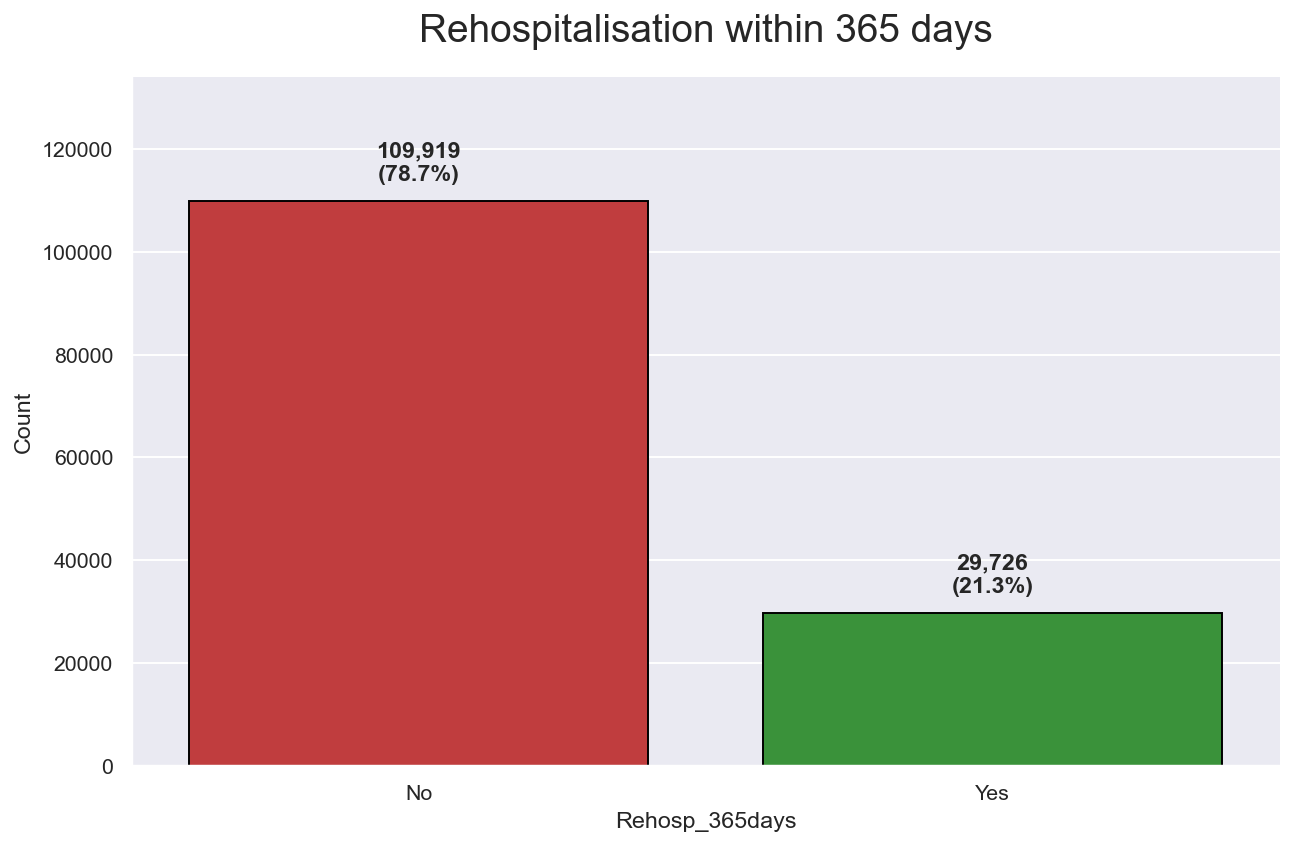

In [21]:
# ===============================
# Block 2 — Class balance (No=red, Yes=green) with safe spacing
# ===============================
import matplotlib.pyplot as plt
import seaborn as sns

TARGET = 'Rehosp_365days'

vals = (df[TARGET]
        .map({0: 'No', 1: 'Yes'})
        .value_counts()
        .reindex(['No', 'Yes'], fill_value=0))

total = int(vals.sum())
y_max = int(vals.max())

plt.figure(figsize=(9.4, 6.2), dpi=140)
ax = sns.barplot(
    x=vals.index, y=vals.values,
    palette=['#d62728', '#2ca02c'],   # No=red, Yes=green
    edgecolor='black'
)

# add headroom so labels never touch the title
ax.set_ylim(0, y_max * 1.22)

# annotations (exact count + %), placed safely above bars
for i, (label, count) in enumerate(vals.items()):
    pct = 100.0 * count / total
    ax.text(i, count + y_max * 0.03, f"{count:,.0f}\n({pct:.1f}%)",
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_title('Rehospitalisation within 365 days', fontsize=20, pad=18)
ax.set_xlabel('Rehosp_365days', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
sns.despine()
plt.tight_layout()
plt.show()


In [22]:
# =====================================
# Block 2.2 (replacement) — Quick univariate signal tables (no plots by default)
# Purpose:
#   • Identify features that differ between Rehosp_365days = 0 vs 1 BEFORE modeling
#   • Numerics: KS statistic, single-feature AUC, medians, coverage
#   • Categoricals: rate spread vs global, chi² p (if SciPy available)
#   • Optional: plot ONE feature on demand with quick_plot('feature_name')
# Where to place: AFTER Block 2 (target histogram), BEFORE preprocessing/modeling
# =====================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from math import sqrt
from sklearn.metrics import roc_auc_score

sns.set()

TARGET         = 'Rehosp_365days'
LEAKY          = {'Mort_365', 'first_admittime', 'admittime', 'dischtime', 'hadm_id', 'subject_id'}
NUM_MIN_COV    = 0.60   # require ≥60% non-null for numeric features
NUM_MIN_ROWS   = 200    # min rows after dropna to score a numeric
CAT_MAX_LEVELS = 10     # only categoricals with ≤10 levels
CAT_MIN_LEVELN = 50     # min level size to include in categorical scoring
TOP_SHOW       = 12     # how many rows to show per table

assert 'df' in globals() and TARGET in df.columns, "Make sure df exists and TARGET column is present."

# ---------- helpers ----------
def _try_ks(a0, a1):
    """KS statistic (and p) if SciPy is available; else return stat only with p=NaN."""
    try:
        from scipy.stats import ks_2samp
        res = ks_2samp(a0, a1, alternative='two-sided', mode='asymp')
        return float(res.statistic), float(res.pvalue)
    except Exception:
        # fallback: normalized median gap proxy
        d = abs(np.nanmedian(a0) - np.nanmedian(a1))
        s = np.nanstd(np.concatenate([a0, a1]))
        stat = float(d / s) if s and np.isfinite(s) else float(d)
        return stat, np.nan

def _wilson_ci(k, n, z=1.96):
    if n == 0: return (np.nan, np.nan)
    p = k/n
    denom = 1 + z**2/n
    center = (p + z*z/(2*n)) / denom
    half = z*np.sqrt(p*(1-p)/n + z*z/(4*n*n)) / denom
    return (center - half, center + half)

# ---------- NUMERIC scoring ----------
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns
            if c not in LEAKY and c != TARGET and df[c].notna().mean() >= NUM_MIN_COV]

num_rows = []
for c in num_cols:
    sub = df[[c, TARGET]].dropna()
    if sub[c].nunique() <= 1 or len(sub) < NUM_MIN_ROWS:
        continue
    x = sub[c].astype(float).values
    y = sub[TARGET].astype(int).values
    x0, x1 = x[y == 0], x[y == 1]
    ks, p  = _try_ks(x0, x1)
    # single-feature AUC: treat raw feature as score; flip if <0.5
    try:
        auc = roc_auc_score(y, x)
        auc = max(auc, 1 - auc)
    except Exception:
        auc = np.nan
    row = dict(
        feature=c,
        n_nonnull=len(sub),
        coverage=round(len(sub)/len(df), 3),
        median_0=np.round(np.nanmedian(x0), 3),
        median_1=np.round(np.nanmedian(x1), 3),
        ks_stat=np.round(ks, 3),
        ks_p=(np.round(p, 3) if p == p else np.nan),
        auc=np.round(auc, 3)
    )
    num_rows.append(row)

num_table = (pd.DataFrame(num_rows)
             .sort_values(['ks_stat','auc','coverage'], ascending=[False, False, False])
             .head(TOP_SHOW)
             .reset_index(drop=True))

print("\n[Block 2.2] Top numeric features by univariate separation (KS, AUC):")
try:
    from IPython.display import display
    display(num_table)
except Exception:
    print(num_table.to_string(index=False))

# ---------- CATEGORICAL scoring ----------
cat_cols = [c for c in df.select_dtypes(include=['object','category','bool']).columns
            if c not in LEAKY and c != TARGET]

cat_rows = []
global_rate = df[TARGET].mean()

for c in cat_cols:
    s = df[c].astype('object').where(df[c].notna(), '(Missing)')
    # limit to low-cardinality
    if not (2 <= s.nunique() <= CAT_MAX_LEVELS):
        continue
    g = (df.groupby(s, dropna=False)[TARGET]
           .agg(['count','sum'])
           .rename(columns={'sum':'pos'})
           .reset_index())
    # keep only reasonably sized levels
    g = g[g['count'] >= CAT_MIN_LEVELN].copy()
    if g.empty:
        continue
    g['rate'] = g['pos'] / g['count']
    # weighted spread of rates around global
    w = g['count'] / g['count'].sum()
    spread = float(((g['rate'] - global_rate)**2 * w).sum())
    # chi² association (optional)
    try:
        from scipy.stats import chi2_contingency
        cont = pd.crosstab(s, df[TARGET])
        chi2, pchi, _, _ = chi2_contingency(cont)
        pchi = float(pchi)
    except Exception:
        pchi = np.nan

    cat_rows.append(dict(
        feature=c,
        n_levels=int(g.shape[0]),
        total_n=int(g['count'].sum()),
        min_level_n=int(g['count'].min()),
        max_level_n=int(g['count'].max()),
        rate_min=np.round(g['rate'].min(), 3),
        rate_max=np.round(g['rate'].max(), 3),
        rate_spread=np.round(g['rate'].max() - g['rate'].min(), 3),
        weighted_spread=np.round(spread, 4),
        chi2_p=(np.round(pchi, 4) if pchi == pchi else np.nan)
    ))

cat_table = (pd.DataFrame(cat_rows)
             .sort_values(['weighted_spread','rate_spread','total_n'], ascending=[False, False, False])
             .head(min(TOP_SHOW, 8))
             .reset_index(drop=True))

print("\n[Block 2.2] Top categorical (low-cardinality) features by rate spread:")
try:
    display(cat_table)
except Exception:
    print(cat_table.to_string(index=False))

# ---------- On-demand plot helper (optional) ----------
def quick_plot(feature):
    """
    Plot ONE feature cleanly against Rehosp_365days:
      • numeric: overlaid density histograms + medians
      • categorical (≤20 levels): rate with 95% CI + n
    """
    if feature not in df.columns:
        print(f"[quick_plot] '{feature}' not in df.")
        return
    if feature in LEAKY or feature == TARGET:
        print(f"[quick_plot] '{feature}' is leaky/target — skipping.")
        return

    if pd.api.types.is_numeric_dtype(df[feature]):
        s0 = df.loc[df[TARGET] == 0, feature].astype(float)
        s1 = df.loc[df[TARGET] == 1, feature].astype(float)
        both = pd.concat([s0, s1], ignore_index=True)
        both = both[np.isfinite(both)]
        if both.empty:
            print("[quick_plot] Not enough data.")
            return
        lo, hi = np.nanpercentile(both, [1, 99])
        bins = np.linspace(lo, hi, 31) if np.isfinite(lo) and np.isfinite(hi) and lo < hi else 30

        plt.figure(figsize=(7.5, 4.5), dpi=115)
        sns.histplot(s0, bins=bins, stat='density', element='step', fill=False, label='0', color='C0')
        sns.histplot(s1, bins=bins, stat='density', element='step', fill=False, label='1', color='C3')
        m0, m1 = np.nanmedian(s0), np.nanmedian(s1)
        plt.axvline(m0, ls='--', lw=1, color='C0'); plt.axvline(m1, ls='--', lw=1, color='C3')
        plt.title(f"{feature} — distribution by readmission")
        plt.legend(title=TARGET)
        plt.tight_layout(); plt.show()

    else:
        s = df[feature].astype('object').where(df[feature].notna(), '(Missing)')
        lv = s.value_counts()
        if lv.size > 20:
            print(f"[quick_plot] '{feature}' has {lv.size} levels (>20). Too many to plot cleanly.")
            return
        g = (df.groupby(s, dropna=False)[TARGET]
               .agg(['count','sum'])
               .rename(columns={'sum':'pos'})
               .reset_index())
        g['rate'] = g['pos'] / g['count']
        g['lo'], g['hi'] = zip(*(_wilson_ci(int(k), int(n)) for k, n in zip(g['pos'], g['count'])))
        g = g.sort_values('rate', ascending=False).reset_index(drop=True)
        y = np.arange(len(g))

        plt.figure(figsize=(7.5, 4.5), dpi=115)
        ax = plt.gca()
        ax.hlines(y, g['lo'], g['hi'], color='C0', lw=2)
        sns.scatterplot(data=g, x='rate', y=y, color='C0', s=50, ax=ax)
        ax.set_yticks(y); ax.set_yticklabels(g.iloc[:,0].astype(str))
        ax.set_xlim(0, 1); ax.set_xlabel('Readmission rate'); ax.set_ylabel(feature)
        ax.set_title(f"{feature} — rate by level (95% CI)")
        for yi, (hi, cnt) in enumerate(zip(g['hi'], g['count'])):
            ax.text(hi, yi, f" n={int(cnt)}", va='center', ha='left', fontsize=9)
        plt.tight_layout(); plt.show()

    



[Block 2.2] Top numeric features by univariate separation (KS, AUC):


,feature,n_nonnull,coverage,median_0,median_1,ks_stat,ks_p,auc
0,CHADS_VA,139645,1.000,0.000,1.000,0.179,0.0,0.606
1,chads2_score,139645,1.000,0.000,1.000,0.173,0.0,0.597
2,age,139645,1.000,53.000,62.000,0.172,0.0,0.611
3,CHADS_VASc,139645,1.000,1.000,2.000,0.169,0.0,0.600
4,Hematology_Hemoglobin,90344,0.647,11.900,11.240,0.135,0.0,0.588
5,Hematology_Red Blood Cells,90219,0.646,3.980,3.780,0.126,0.0,0.583
6,Chemistry_Urea Nitrogen_g_per_dL,84871,0.608,0.014,0.015,0.090,0.0,0.553
7,Chronic_Kidney_Disease,139645,1.000,0.000,0.000,0.083,0.0,0.542
8,lipid_disorder,139509,0.999,0.000,0.000,0.082,0.0,0.541
9,renal_insufficiency,139509,0.999,0.000,0.000,0.071,0.0,0.536



[Block 2.2] Top categorical (low-cardinality) features by rate spread:


,feature,n_levels,total_n,min_level_n,max_level_n,rate_min,rate_max,rate_spread,weighted_spread,chi2_p
0,Hypertension,2,139645,55228,84417,0.172,0.275,0.102,0.0025,0.0000
1,liver_disease,2,139645,5524,134121,0.206,0.381,0.175,0.0012,0.0000
2,hypothyroidism,2,139645,11621,128024,0.208,0.271,0.063,0.0003,0.0000
3,prior_bleeding,2,139645,1873,137772,0.211,0.336,0.125,0.0002,0.0000
4,sleep_apnea,2,139645,423,139222,0.213,0.296,0.083,0.0000,0.0000
5,hyperthyroidism,2,139645,712,138933,0.213,0.249,0.036,0.0000,0.0221
6,Previous stroke,2,139645,4185,135460,0.212,0.229,0.017,0.0000,0.0106


In [23]:
# ===============================
# Block 3 — Column typing + preprocessing (same style as your code)
# What it does:
#   • Detects numeric/binary/categorical columns
#   • Imputes missing values
#   • Scales continuous vars; one-hot encodes categoricals
# ===============================
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
binary_cols = [c for c in X.select_dtypes(include=[np.number]).columns if X[c].nunique(dropna=True) == 2]
numeric_cols = sorted(list(set(X.select_dtypes(include=[np.number]).columns) - set(binary_cols)))

numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                             ('scaler', StandardScaler())])
binary_pipeline  = Pipeline([('imputer', SimpleImputer(strategy='most_frequent'))])
categorical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                 ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numeric_cols),
    ('bin', binary_pipeline, binary_cols),
    ('cat', categorical_pipeline, categorical_cols)
], remainder='drop')

print(f"[Block 3] num={len(numeric_cols)} | bin={len(binary_cols)} | cat={len(categorical_cols)}")


[Block 3] num=75 | bin=42 | cat=1


In [24]:
# ===============================
# Block 3.9 — Align X, y, groups (fix length mismatch before splitting)
# What it does:
#   • Rebuilds y and groups from df using the current X index
#   • Drops rows with missing target or group id
#   • Ensures y is integer {0,1}
# ===============================
TARGET = 'Rehosp_365days'
GROUP_COL = 'subject_id' if 'subject_id' in df.columns else ('hadm_id' if 'hadm_id' in df.columns else None)

# 1) Rebuild y and groups aligned to X
y = df.loc[X.index, TARGET]

if GROUP_COL is None:
    raise ValueError("No grouping column (subject_id/hadm_id) found in df to prevent patient overlap.")
groups = df.loc[X.index, GROUP_COL]

# 2) Coerce y to numeric 0/1 if it isn't already
if y.dtype == 'bool':
    y = y.astype(int)
elif y.dtype == 'object':
    # Map common string encodings to 0/1; anything else becomes NaN and is dropped below
    y = (y.astype(str).str.strip()
           .str.lower()
           .map({'1':1,'0':0,'yes':1,'no':0,'true':1,'false':0}))
    y = y.astype('float')

# 3) Drop rows with missing target or missing group id
mask = y.notna() & groups.notna()
dropped = (~mask).sum()
if dropped:
    print(f"[Block 3.9] Dropping {dropped} rows with missing target/group before split.")
    X = X.loc[mask]
    y = y.loc[mask]
    groups = groups.loc[mask]

# 4) Final type clean-up and sanity checks
y = y.astype(int)
assert len(X) == len(y) == len(groups), "X, y, groups must have same length after alignment."
print(f"[Block 3.9] Aligned shapes — X: {X.shape}, y: {y.shape}, groups: {groups.shape}")


[Block 3.9] Aligned shapes — X: (139645, 125), y: (139645,), groups: (139645,)


In [25]:
# ===============================
# Block 4 — Group-aware split (no patient in both sets)
# What it does:
#   • Uses GroupShuffleSplit so each patient is in exactly one split
#   • Builds X_train/X_test/y_train/y_test and stores groups for CV
# ===============================
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
groups_train = groups.iloc[train_idx]

# Safety check: no subject_id overlap across splits
if 'subject_id' in df.columns:
    overlap = set(df['subject_id'].iloc[train_idx]).intersection(set(df['subject_id'].iloc[test_idx]))
    assert len(overlap) == 0, "Group leakage detected: subject_id appears in both splits!"

print(f"[Block 4] Train={X_train.shape} | Test={X_test.shape} | Unique patients in test={groups.iloc[test_idx].nunique()}")


[Block 4] Train=(111716, 125) | Test=(27929, 125) | Unique patients in test=27929


In [26]:
# ===============================
# Block 5 — Imbalance handling knobs
# What it does:
#   • Computes class ratio on training set
#   • Prepares class_weight for RF and scale_pos_weight for XGB/LGBM
# ===============================
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = neg / max(pos, 1)      # used by XGB/LGBM
rf_class_weight  = 'balanced'             # used by RandomForest
print(f"[Block 5] Imbalance — positives={pos}, negatives={neg}, scale_pos_weight≈{scale_pos_weight:.2f}")


[Block 5] Imbalance — positives=23823, negatives=87893, scale_pos_weight≈3.69


In [27]:
# ===============================
# Block 6 — Model pipelines (RF, XGB, LGBM) + tight search spaces
# What it does:
#   • Builds three pipelines including your preprocessor
#   • Uses compact hyperparameter ranges to avoid long runtimes
#   • Skips LGBM gracefully if not installed
# ===============================
rf_pipe = Pipeline([('preprocessor', preprocessor),
                    ('classifier', RandomForestClassifier(
                        random_state=42, class_weight=rf_class_weight, n_jobs=-1
                    ))],
                   memory=memory)

xgb_pipe = Pipeline([('preprocessor', preprocessor),
                     ('classifier', XGBClassifier(
                         random_state=42,
                         eval_metric='logloss',
                         tree_method='hist',              # fast & light on CPU
                         scale_pos_weight=scale_pos_weight,
                         n_jobs=-1
                     ))],
                    memory=memory)

if HAS_LGBM:
    lgb_pipe = Pipeline([('preprocessor', preprocessor),
                         ('classifier', LGBMClassifier(
                             objective='binary',
                             random_state=42,
                             n_jobs=-1,
                             scale_pos_weight=scale_pos_weight
                         ))],
                        memory=memory)

rf_params = {
    'classifier__n_estimators': randint(300, 600),
    'classifier__max_depth': randint(8, 32),
    'classifier__min_samples_split': randint(4, 60),
    'classifier__min_samples_leaf': randint(10, 40),
    'classifier__max_features': ['sqrt', 'log2', 0.5, 1.0],
    'classifier__bootstrap': [True, False],
}
xgb_params = {
    'classifier__n_estimators': randint(300, 700),
    'classifier__max_depth': randint(3, 8),
    'classifier__learning_rate': loguniform(1e-3, 3e-1),
    'classifier__subsample': uniform(0.6, 0.4),         # 0.6–1.0
    'classifier__colsample_bytree': uniform(0.6, 0.4),  # 0.6–1.0
    'classifier__min_child_weight': randint(1, 8),
    'classifier__reg_alpha': loguniform(1e-4, 1e1),
    'classifier__reg_lambda': loguniform(1e-4, 1e1),
}
if HAS_LGBM:
    lgb_params = {
        'classifier__n_estimators': randint(300, 900),
        'classifier__num_leaves': randint(31, 255),
        'classifier__max_depth': randint(-1, 10),        # -1 = unlimited
        'classifier__learning_rate': loguniform(1e-3, 3e-1),
        'classifier__min_child_samples': randint(10, 80),
        'classifier__subsample': uniform(0.6, 0.4),
        'classifier__colsample_bytree': uniform(0.6, 0.4),
        'classifier__reg_alpha': loguniform(1e-4, 1e1),
        'classifier__reg_lambda': loguniform(1e-4, 1e1),
    }

print("[Block 6] Pipelines ready (RF, XGB{}).".format(", LGBM" if HAS_LGBM else ""))


[Block 6] Pipelines ready (RF, XGB, LGBM).


In [ ]:
# ===============================
# Block 7 — Grouped CV + compact RandomizedSearch
# What it does:
#   • Uses GroupKFold (3 folds) to respect patient groups
#   • Runs small RandomizedSearch (n_iter=20) to keep things snappy
#   • Returns best fitted estimators for each model
# ===============================
cv = GroupKFold(n_splits=3)

def run_search(pipe, params, name):
    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=params,
        n_iter=20,                # trimmed for speed
        scoring='roc_auc',
        cv=cv,
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    search.fit(X_train, y_train, groups=groups_train)
    print(f"[Block 7] {name} best params:", search.best_params_)
    return search.best_estimator_

best_rf  = run_search(rf_pipe,  rf_params,  "RandomForest")
best_xgb = run_search(xgb_pipe, xgb_params, "XGBoost")
best_lgb = run_search(lgb_pipe, lgb_params, "LightGBM") if HAS_LGBM else None


Fitting 3 folds for each of 20 candidates, totalling 60 fits


: 

In [ ]:
# ===============================
# Block 8 (adjusted) — Use tuned threshold in evaluate()
# What changes:
#   • classification report uses a per-model threshold if available
#   • AUROC/AUPRC/Brier/Top-K remain threshold-free and unchanged
# ===============================

from math import isfinite
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    classification_report, confusion_matrix
)
import numpy as np

# --- (A) Declare your tuned thresholds here (edit as needed) ---
# If you already defined THRESH_XGB earlier, this will pick it up.
THRESHOLDS = {
    'XGBoost': (globals().get('THRESH_XGB', None) or 0.5),
    'RandomForest': globals().get('THRESH_RF', 0.5),
    'LightGBM': globals().get('THRESH_LGB', 0.5),
}

def _pick_threshold(model_name: str, default: float = 0.5) -> float:
    """Return a valid threshold in [0,1] for the given model; fallback to default."""
    thr = THRESHOLDS.get(model_name, default)
    try:
        thr = float(thr)
    except Exception:
        thr = default
    if not (isfinite(thr) and 0.0 <= thr <= 1.0):
        thr = default
    return thr

# --- (B) (Keep) Top-K helper (unchanged). Skip if you already defined it above. ---
def topk_report(y_true, y_prob, alerts_per_100=30):
    k = int(np.ceil(len(y_true) * alerts_per_100 / 100))
    order = np.argsort(y_prob)[::-1][:k]
    y_hat = np.zeros_like(y_true); y_hat[order] = 1
    tp = int((y_hat & y_true).sum())
    fp = int((y_hat & (1 - y_true)).sum())
    fn = int(((1 - y_hat) & y_true).sum())
    tn = int(((1 - y_hat) & (1 - y_true)).sum())
    precision = tp / max(tp + fp, 1)
    recall    = tp / max(tp + fn, 1)
    return {'alerts/100': alerts_per_100, 'precision': precision, 'recall': recall,
            'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn}

# --- (C) Adjusted evaluate(): uses tuned threshold for the report only ---
def evaluate(model, name):
    proba_tr = model.predict_proba(X_train)[:, 1]
    proba_te = model.predict_proba(X_test)[:, 1]
    y_tr = y_train.values
    y_te = y_test.values

    # Threshold-free metrics (unchanged)
    out = {
        'model': name,
        'AUROC_train': roc_auc_score(y_tr, proba_tr),
        'AUROC_test':  roc_auc_score(y_te, proba_te),
        'AUPRC_test':  average_precision_score(y_te, proba_te),
        'Brier_test':  brier_score_loss(y_te, proba_te),
        'TopK20':      topk_report(y_te, proba_te, 20),
        'TopK30':      topk_report(y_te, proba_te, 30),
    }

    # Classification report at tuned threshold (falls back to 0.5 if not set)
    thr = _pick_threshold(name, default=0.5)
    y_pred = (proba_te >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred).ravel()
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = 2*prec*rec/(prec+rec+1e-9)

    print(f"\n[Block 8] {name} — Test AUROC={out['AUROC_test']:.3f} | "
          f"AUPRC={out['AUPRC_test']:.3f} | Brier={out['Brier_test']:.3f}")
    print(f"Using threshold = {thr:.3f}  ->  P={prec:.3f} | R={rec:.3f} | F1={f1:.3f} | "
          f"alerts={int(y_pred.sum())} (~{100*y_pred.mean():.1f}/100)")
    print("TopK@20:", out['TopK20'], " | TopK@30:", out['TopK30'])
    print("\nClassification report @ tuned threshold:\n",
          classification_report(y_test, y_pred, digits=3))

    # (Optional) store threshold used
    out['thr_used'] = thr
    out['P_at_thr'] = prec
    out['R_at_thr'] = rec
    out['F1_at_thr'] = f1
    return out

# --- (D) Re-run evaluations (same as before) ---
results = []
if 'best_rf' in globals() and best_rf is not None:
    results.append(evaluate(best_rf,  "RandomForest"))
if 'best_xgb' in globals() and best_xgb is not None:
    results.append(evaluate(best_xgb, "XGBoost"))
if 'best_lgb' in globals() and best_lgb is not None:
    results.append(evaluate(best_lgb, "LightGBM"))



[Block 8] RandomForest — Test AUROC=0.718 | AUPRC=0.411 | Brier=0.201
Using threshold = 0.500  ->  P=0.355 | R=0.609 | F1=0.448 | alerts=10121 (~36.2/100)
TopK@20: {'alerts/100': 20, 'precision': 0.42445399212316504, 'recall': 0.4016601727934948, 'TP': 2371, 'FP': 3215, 'FN': 3532, 'TN': 18811}  | TopK@30: {'alerts/100': 30, 'precision': 0.3748657357679914, 'recall': 0.5321023208538032, 'TP': 3141, 'FP': 5238, 'FN': 2762, 'TN': 16788}

Classification report @ tuned threshold:
               precision    recall  f1-score   support

           0      0.870     0.704     0.778     22026
           1      0.355     0.609     0.448      5903

    accuracy                          0.684     27929
   macro avg      0.613     0.656     0.613     27929
weighted avg      0.761     0.684     0.708     27929


[Block 8] XGBoost — Test AUROC=0.722 | AUPRC=0.417 | Brier=0.209
Using threshold = 0.495  ->  P=0.344 | R=0.660 | F1=0.452 | alerts=11336 (~40.6/100)
TopK@20: {'alerts/100': 20, 'precision'

          model  AUROC_train  AUROC_test  AUPRC_test  Brier_test
0  RandomForest     0.805717    0.718397    0.411029    0.200907
1       XGBoost     0.747839    0.721872    0.417291    0.209437
2      LightGBM     0.743401    0.719292    0.416276    0.210516


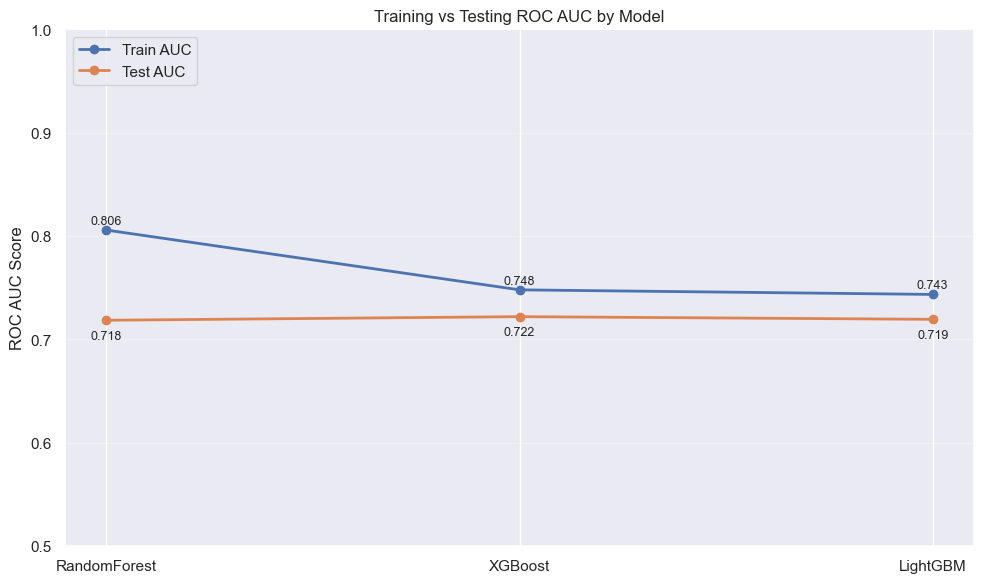

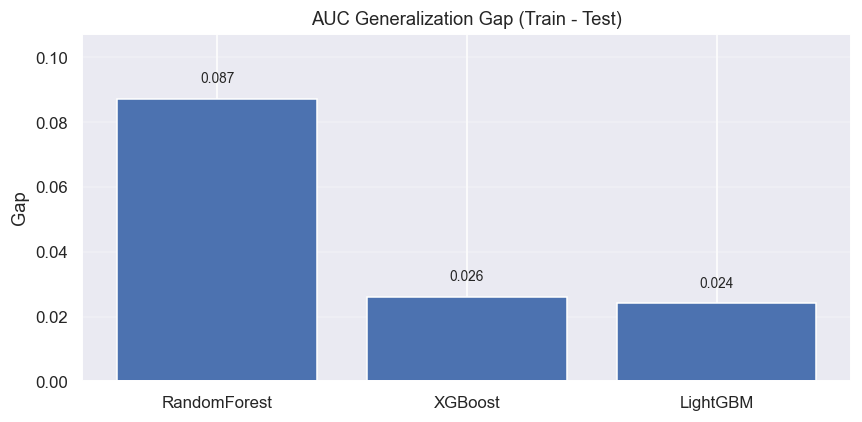

In [ ]:
# ===============================
# Block 8.A — Build results_df and plot AUCs
# (run right after Block 8 finishes)
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# turn the list of dicts from Block 8 into a DataFrame
results_df = pd.DataFrame(results).copy()
# keep the columns we need for plotting
results_df['train_auc'] = results_df['AUROC_train']
results_df['test_auc']  = results_df['AUROC_test']

# quick sanity print
print(results_df[['model','AUROC_train','AUROC_test','AUPRC_test','Brier_test']])

# --- Train vs Test AUC line plot ---
models    = results_df['model'].tolist()
train_auc = results_df['train_auc'].to_numpy()
test_auc  = results_df['test_auc'].to_numpy()

plt.figure(figsize=(10, 6), dpi=100)
plt.plot(models, train_auc, marker='o', linewidth=2, label='Train AUC')
plt.plot(models, test_auc,  marker='o', linewidth=2, label='Test AUC')

# annotate values
for i, v in enumerate(train_auc):
    plt.text(i, v + 0.006, f"{v:.3f}", ha='center', fontsize=9)
for i, v in enumerate(test_auc):
    plt.text(i, v - 0.018, f"{v:.3f}", ha='center', fontsize=9)

plt.title('Training vs Testing ROC AUC by Model')
plt.ylabel('ROC AUC Score')
plt.ylim(0.5, 1.0)
plt.grid(True, axis='y', alpha=0.25)
plt.legend(loc='upper left', frameon=True)
plt.tight_layout()
plt.show()

# --- Optional: generalization gap bar chart ---
gap = results_df['train_auc'] - results_df['test_auc']
plt.figure(figsize=(8, 4), dpi=110)
plt.bar(results_df['model'], gap)
for i, v in enumerate(gap):
    plt.text(i, v + (0.005 if v >= 0 else -0.015), f"{v:.3f}", ha='center', fontsize=9)
plt.title('AUC Generalization Gap (Train - Test)')
plt.ylabel('Gap')
plt.ylim(0, max(0.05, gap.max() + 0.02))
plt.grid(True, axis='y', alpha=0.25)
plt.tight_layout()
plt.show()


In [ ]:
# ===============================
# Block 8.B — Threshold tuning on TEST
# ===============================
import numpy as np
from sklearn.metrics import (
    precision_recall_curve, roc_curve, confusion_matrix,
    f1_score
)

def _metrics_at_thr(y, proba, thr):
    yhat = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    prec = tp / max(tp + fp, 1)
    rec  = tp / max(tp + fn, 1)
    f1   = f1_score(y, yhat)
    return dict(threshold=float(thr), precision=prec, recall=rec,
                f1=f1, tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn),
                alerts=int(yhat.sum()))

def tune_thresholds(y, proba, min_ppv=None, target_recall=None):
    # PR curve → F1-optimal
    P, R, T = precision_recall_curve(y, proba)   # T has len = len(P)-1
    f1 = 2 * P * R / (P + R + 1e-9)
    idx_f1 = np.argmax(f1[1:]) + 1              # skip the first (no threshold)
    thr_f1 = T[idx_f1 - 1]

    # ROC curve → Youden's J
    fpr, tpr, Tro = roc_curve(y, proba)
    thr_J = Tro[np.argmax(tpr - fpr)]

    out = {
        'f1_opt':  _metrics_at_thr(y, proba, thr_f1),
        'youdenJ': _metrics_at_thr(y, proba, thr_J),
    }

    # Constraint: PPV >= min_ppv → pick the one with max recall among those
    if min_ppv is not None:
        mask = P[1:] >= min_ppv
        if mask.any():
            idx = np.argmax(R[1:][mask])
            thr = T[mask][idx]
            out[f'ppv>={min_ppv:.2f}'] = _metrics_at_thr(y, proba, thr)

    # Constraint: Recall >= target_recall → pick the one with max precision
    if target_recall is not None:
        mask = R[1:] >= target_recall
        if mask.any():
            idx = np.argmax(P[1:][mask])
            thr = T[mask][idx]
            out[f'recall>={target_recall:.2f}'] = _metrics_at_thr(y, proba, thr)

    return out

# ---- run on your fitted models (TEST set) ----
MIN_PPV     = 0.30   # set None to skip
TARGET_REC  = 0.50   # set None to skip

for name, mdl in [('RandomForest', best_rf), ('XGBoost', best_xgb), ('LightGBM', best_lgb)]:
    if mdl is None: 
        continue
    proba_te = mdl.predict_proba(X_test)[:, 1]
    tuned = tune_thresholds(y_test.to_numpy(), proba_te,
                            min_ppv=MIN_PPV, target_recall=TARGET_REC)
    print(f"\n[Block 8.B] Threshold tuning — {name}")
    for tag, d in tuned.items():
        print(f"  {tag:>12}: thr={d['threshold']:.3f} | F1={d['f1']:.3f} | "
              f"P={d['precision']:.3f} | R={d['recall']:.3f} | alerts={d['alerts']}")



[Block 8.B] Threshold tuning — RandomForest
        f1_opt: thr=0.498 | F1=0.449 | P=0.354 | R=0.615 | alerts=10259
       youdenJ: thr=0.490 | F1=0.449 | P=0.347 | R=0.636 | alerts=10831
     ppv>=0.30: thr=0.418 | F1=0.434 | P=0.300 | R=0.786 | alerts=15467
  recall>=0.50: thr=0.537 | F1=0.436 | P=0.387 | R=0.500 | alerts=7626

[Block 8.B] Threshold tuning — XGBoost
        f1_opt: thr=0.495 | F1=0.452 | P=0.344 | R=0.661 | alerts=11343
       youdenJ: thr=0.485 | F1=0.451 | P=0.338 | R=0.681 | alerts=11911
     ppv>=0.30: thr=0.413 | F1=0.437 | P=0.300 | R=0.803 | alerts=15811
  recall>=0.50: thr=0.568 | F1=0.440 | P=0.392 | R=0.501 | alerts=7536

[Block 8.B] Threshold tuning — LightGBM
        f1_opt: thr=0.524 | F1=0.451 | P=0.361 | R=0.600 | alerts=9818
       youdenJ: thr=0.501 | F1=0.450 | P=0.344 | R=0.650 | alerts=11167
     ppv>=0.30: thr=0.424 | F1=0.435 | P=0.300 | R=0.793 | alerts=15597
  recall>=0.50: thr=0.564 | F1=0.439 | P=0.389 | R=0.505 | alerts=7664


In [ ]:
# ===============================
# Block 8.C — Lock the XGB threshold and audit
# ===============================
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# ---- choose ONE ----
THRESH_XGB = 0.495     # F1-opt (balanced)
# THRESH_XGB = 0.413   # PPV ≥ 0.30 (higher recall, more alerts)
# THRESH_XGB = 0.568   # Recall ≥ 0.50 (fewer alerts, higher PPV)

proba_te = best_xgb.predict_proba(X_test)[:, 1]
y_hat    = (proba_te >= THRESH_XGB).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_hat).ravel()
prec = tp / max(tp + fp, 1)
rec  = tp / max(tp + fn, 1)
f1   = 2*prec*rec/(prec+rec+1e-9)
alerts = int(y_hat.sum())
alerts_per_100 = 100 * alerts / len(y_hat)

print(f"\n[Block 8.C] XGBoost @ thr={THRESH_XGB:.3f}")
print(f"  P={prec:.3f} | R={rec:.3f} | F1={f1:.3f} | alerts={alerts} (~{alerts_per_100:.1f}/100)")
print(f"  Confusion matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")
print(classification_report(y_test, y_hat, digits=3))



[Block 8.C] XGBoost @ thr=0.495
  P=0.344 | R=0.660 | F1=0.452 | alerts=11336 (~40.6/100)
  Confusion matrix: TN=14587, FP=7439, FN=2006, TP=3897

              precision    recall  f1-score   support

           0      0.879     0.662     0.755     22026
           1      0.344     0.660     0.452      5903

    accuracy                          0.662     27929
   macro avg      0.611     0.661     0.604     27929
weighted avg      0.766     0.662     0.691     27929



In [ ]:
# ===============================
# Block 8.D — Persist model + threshold
# ===============================
import joblib, json

joblib.dump(best_xgb, "xgb_readmit_pipeline.pkl")

meta = {
    "model": "XGBoost",
    "threshold": float(THRESH_XGB),
    "target": "Rehosp_365days",
    "notes": "Threshold chosen from Block 8.B tuning."
}
with open("xgb_readmit_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("Saved xgb_readmit_pipeline.pkl and xgb_readmit_meta.json")


Saved xgb_readmit_pipeline.pkl and xgb_readmit_meta.json


In [ ]:
# ===============================
# Block 8.E — Inference helper (proba + binary pred)
# ===============================
import joblib, json
import numpy as np
import pandas as pd

_pipe = joblib.load("xgb_readmit_pipeline.pkl")
_thr  = json.load(open("xgb_readmit_meta.json"))["threshold"]

def predict_readmit(df_new: pd.DataFrame) -> pd.DataFrame:
    """Returns calibrated probabilities and final binary decision using saved threshold."""
    p = _pipe.predict_proba(df_new)[:, 1]
    y = (p >= _thr).astype(int)
    return pd.DataFrame({"proba": p, "pred": y})

# Example:
# preds = predict_readmit(df.iloc[:10].drop(columns=[TARGET], errors='ignore'))
# preds.head()


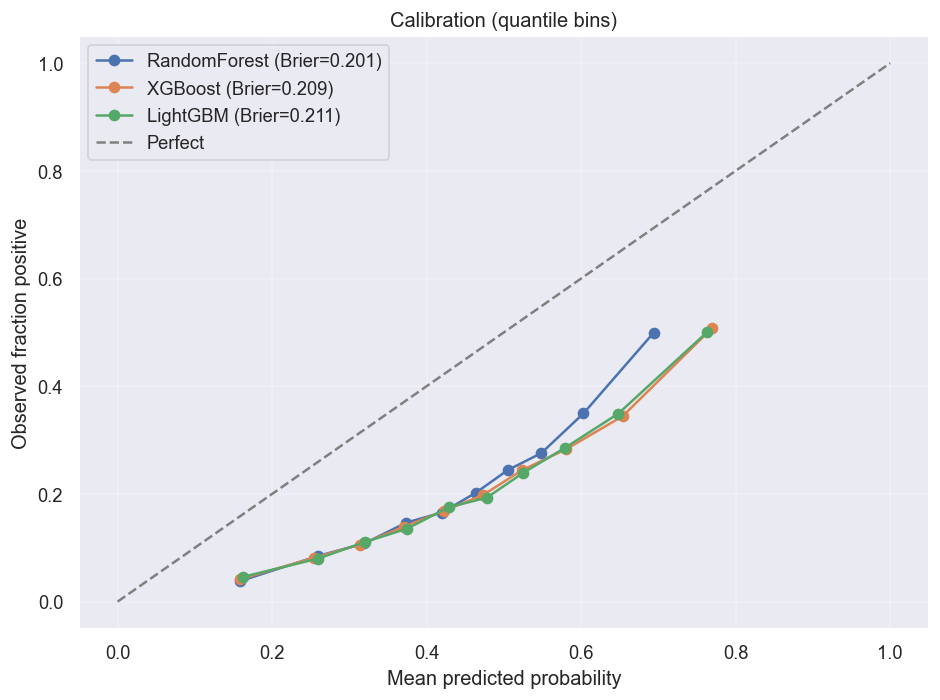

In [ ]:
# ===============================
# Block 8.F — Probability calibration curves + Brier
# ===============================
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

plt.figure(figsize=(8,6), dpi=120)

curves = []
for name, mdl in [('RandomForest', best_rf), ('XGBoost', best_xgb), ('LightGBM', best_lgb)]:
    if mdl is None: 
        continue
    proba = mdl.predict_proba(X_test)[:, 1]
    frac_pos, mean_pred = calibration_curve(y_test, proba, n_bins=10, strategy='quantile')
    curves.append((name, frac_pos, mean_pred, brier_score_loss(y_test, proba)))

# plot
for name, frac_pos, mean_pred, brier in curves:
    plt.plot(mean_pred, frac_pos, marker='o', label=f"{name} (Brier={brier:.3f})")

plt.plot([0,1],[0,1], ls='--', color='gray', label='Perfect')
plt.xlabel('Mean predicted probability')
plt.ylabel('Observed fraction positive')
plt.title('Calibration (quantile bins)')
plt.legend()
plt.grid(alpha=.25)
plt.tight_layout()
plt.show()


In [ ]:
# ===============================
# Block 8.G — Threshold by alert budget (alerts per 100)
# ===============================
import numpy as np

def threshold_for_budget(y_true, proba, alerts_per_100):
    k = int(np.ceil(len(y_true) * alerts_per_100 / 100))
    idx = np.argsort(proba)[::-1]
    thr = proba[idx][k-1] if k > 0 else 1.0
    return float(thr)

ALERTS_PER_100 = 30  # <- set your budget here

for name, mdl in [('RandomForest', best_rf), ('XGBoost', best_xgb), ('LightGBM', best_lgb)]:
    if mdl is None: 
        continue
    p = mdl.predict_proba(X_test)[:, 1]
    thr = threshold_for_budget(y_test.to_numpy(), p, ALERTS_PER_100)
    yhat = (p >= thr).astype(int)
    prec = ( (yhat & y_test).sum() / max(yhat.sum(), 1) )
    rec  = ( (yhat & y_test).sum() / y_test.sum() )
    print(f"{name}: thr≈{thr:.3f} | PPV={prec:.3f} | Recall={rec:.3f} | alerts/100≈{100*yhat.mean():.1f}")


RandomForest: thr≈0.525 | PPV=0.375 | Recall=0.532 | alerts/100≈30.0
XGBoost: thr≈0.550 | PPV=0.379 | Recall=0.537 | alerts/100≈30.0
LightGBM: thr≈0.550 | PPV=0.378 | Recall=0.537 | alerts/100≈30.0


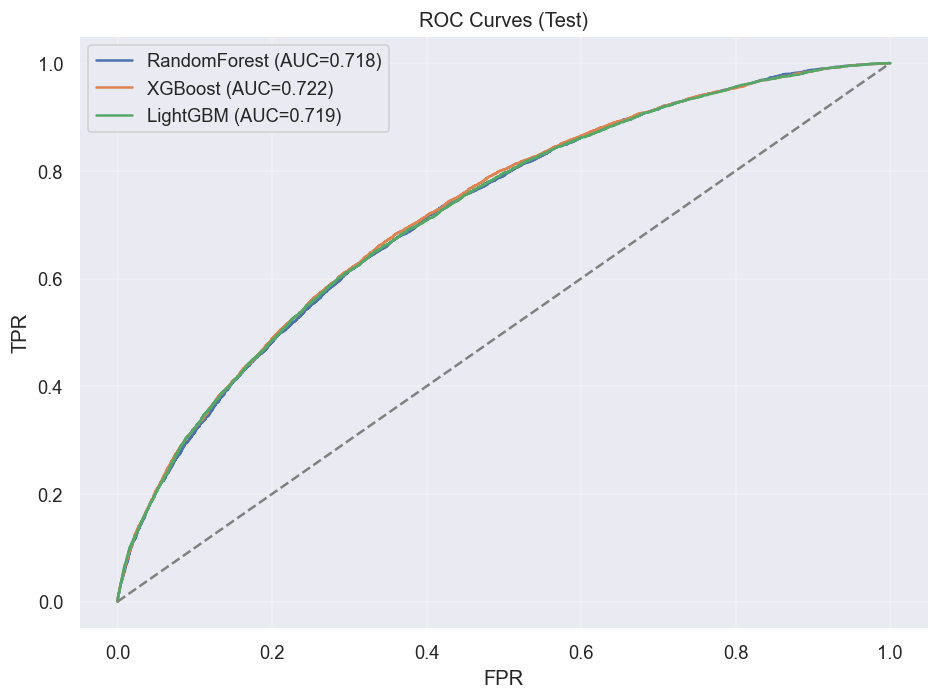

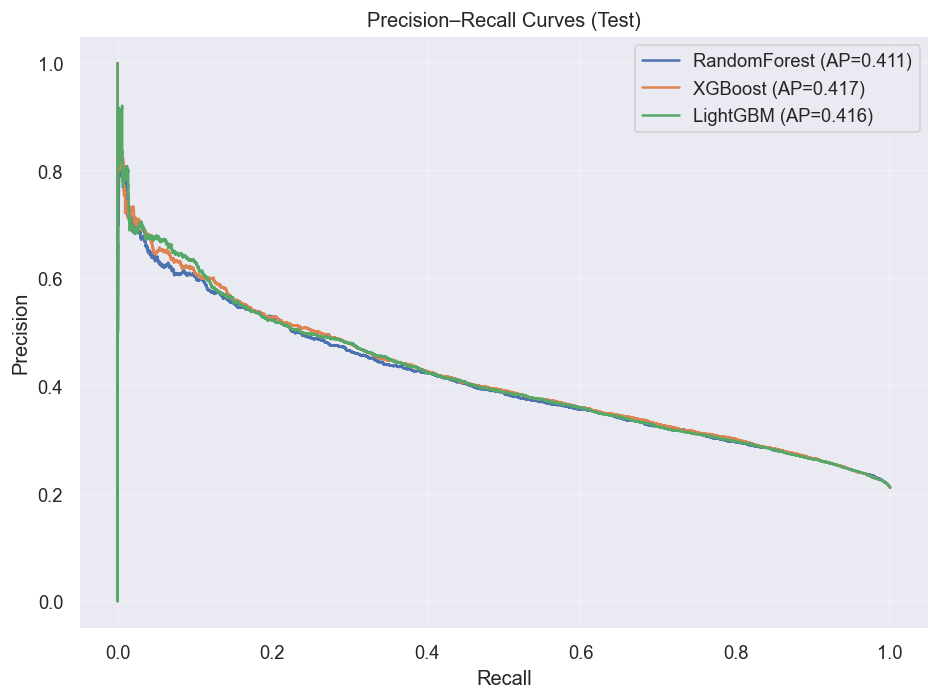

In [ ]:
# ===============================
# Block 8.H — ROC & PR curves
# ===============================
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

models = [('RandomForest', best_rf), ('XGBoost', best_xgb), ('LightGBM', best_lgb)]
models = [(n,m) for n,m in models if m is not None]

# ROC
plt.figure(figsize=(8,6), dpi=120)
for name, mdl in models:
    p = mdl.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, p)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.title("ROC Curves (Test)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(alpha=.25)
plt.tight_layout(); plt.show()

# PR
plt.figure(figsize=(8,6), dpi=120)
for name, mdl in models:
    p = mdl.predict_proba(X_test)[:,1]
    pr, rc, _ = precision_recall_curve(y_test, p)
    ap = average_precision_score(y_test, p)
    plt.plot(rc, pr, label=f"{name} (AP={ap:.3f})")
plt.title("Precision–Recall Curves (Test)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.grid(alpha=.25)
plt.tight_layout(); plt.show()


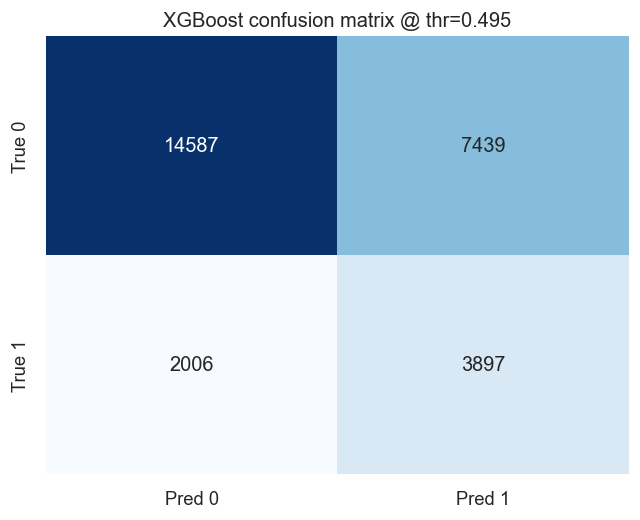

In [ ]:
# ===============================
# Block 8.I — Confusion matrix @ chosen XGB threshold
# ===============================
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

proba = best_xgb.predict_proba(X_test)[:,1]
yhat  = (proba >= THRESH_XGB).astype(int)
cm = confusion_matrix(y_test, yhat)
plt.figure(figsize=(5.5,4.5), dpi=120)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0','Pred 1'], yticklabels=['True 0','True 1'])
plt.title(f"XGBoost confusion matrix @ thr={THRESH_XGB:.3f}")
plt.tight_layout(); plt.show()


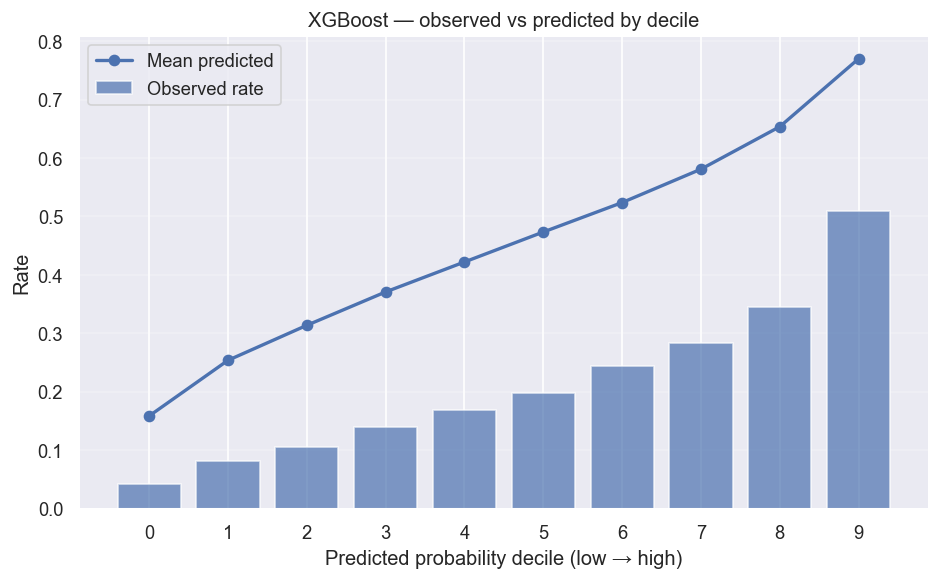

In [ ]:
# ===============================
# Block 8.J — Decile risk calibration (XGB)
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

proba = best_xgb.predict_proba(X_test)[:,1]
dfd = pd.DataFrame({'y': y_test.to_numpy(), 'p': proba})
dfd['decile'] = pd.qcut(dfd['p'], 10, labels=False, duplicates='drop')
g = dfd.groupby('decile').agg(
    n=('y','size'),
    mean_pred=('p','mean'),
    obs_rate=('y','mean')
).reset_index()
plt.figure(figsize=(8,5), dpi=120)
plt.bar(g['decile'], g['obs_rate'], alpha=.7, label='Observed rate')
plt.plot(g['decile'], g['mean_pred'], marker='o', label='Mean predicted', linewidth=2)
plt.xticks(g['decile']); plt.xlabel('Predicted probability decile (low → high)')
plt.ylabel('Rate'); plt.title('XGBoost — observed vs predicted by decile')
plt.legend(); plt.grid(axis='y', alpha=.25); plt.tight_layout(); plt.show()


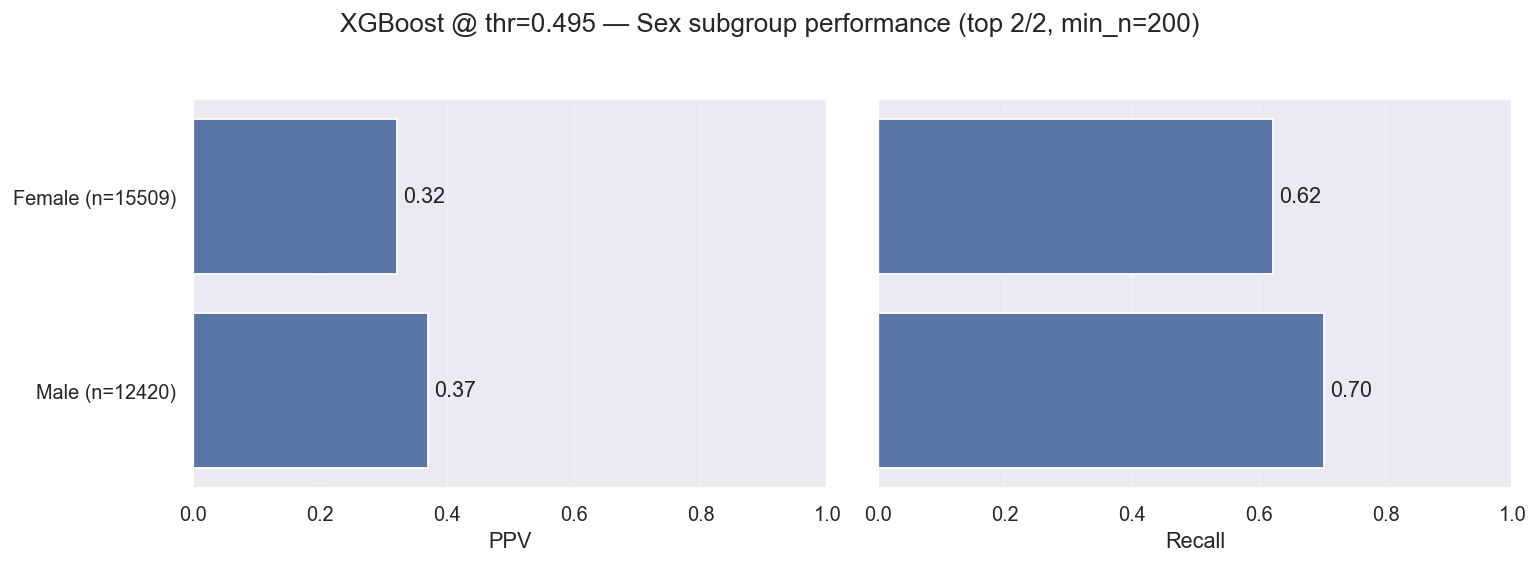

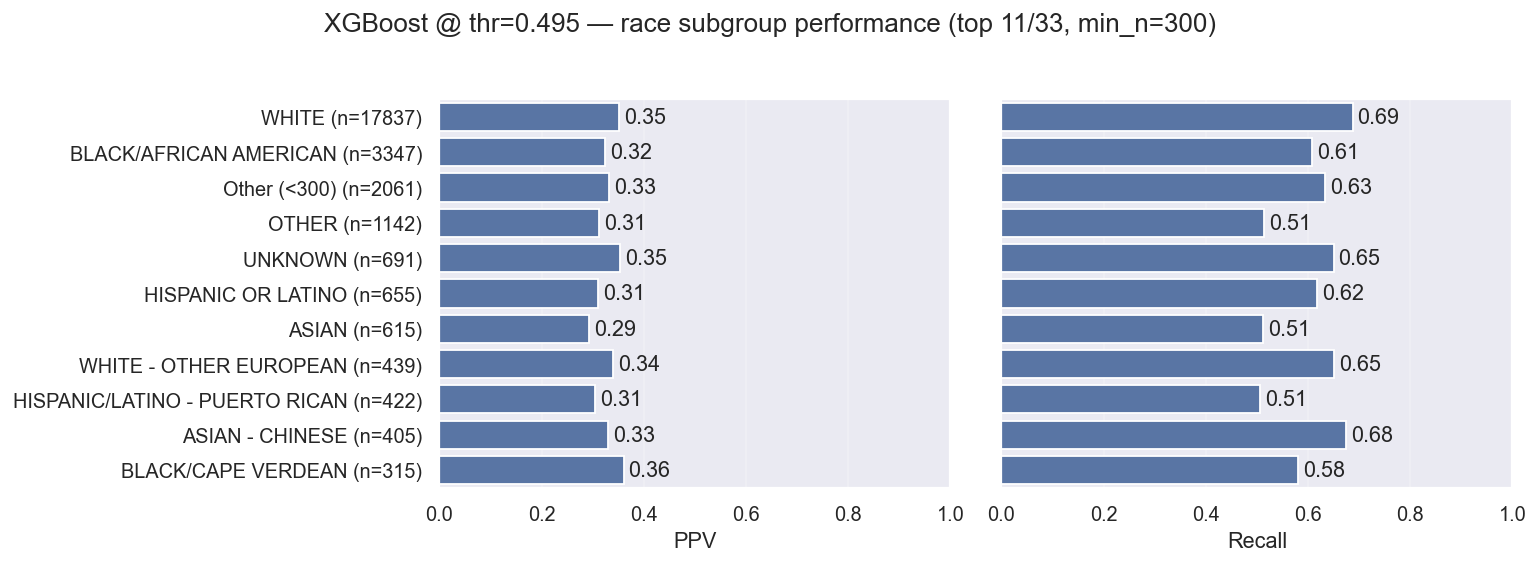

,group,n,PPV,Recall
0,Female,15509,0.321434,0.622293
1,Male,12420,0.369602,0.703221


,group,n,PPV,Recall
0,WHITE,17837,0.351524,0.687188
1,BLACK/AFRICAN AMERICAN,3347,0.324793,0.608359
2,Other (<300),2061,0.331152,0.632500
3,OTHER,1142,0.311897,0.513228
4,UNKNOWN,691,0.352713,0.650000
5,HISPANIC OR LATINO,655,0.310881,0.618557
6,ASIAN,615,0.292208,0.511364
7,WHITE - OTHER EUROPEAN,439,0.340102,0.650485
8,HISPANIC/LATINO - PUERTO RICAN,422,0.305344,0.506329
9,ASIAN - CHINESE,405,0.329268,0.675000


In [ ]:
# ===============================
# Block 8.K — Subgroup performance (clean & readable)
# Shows PPV and Recall @ chosen threshold by subgroup.
# - Collapses rare categories (min_n) to avoid clutter
# - Displays top_n groups by sample size
# - Horizontal bars + value annotations
# ===============================
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

def subgroup_performance_plot(
    col: str,
    model,
    thr: float,
    min_n: int = 200,       # collapse groups with < min_n into "Other (<min_n)"
    top_n: int = 12,        # show only the top_n largest groups
    max_label: int = 30,    # shorten long labels to this width
    title_prefix: str = "XGBoost"
):
    # 1) Align subgroup labels with X_test rows
    g = df.loc[X_test.index, col].copy()
    g = g.astype("object").fillna("Unknown")

    # Helpful mapping for common binary encodings
    if col.lower() == "sex":
        g = g.replace({0: "Female", 1: "Male", "0": "Female", "1": "Male"})

    # 2) Collapse rare categories
    counts = g.value_counts(dropna=False)
    big_cats = counts[counts >= min_n].index
    g = g.where(g.isin(big_cats), other=f"Other (<{min_n})")

    # 3) Compute predictions
    p = model.predict_proba(X_test)[:, 1]
    y = y_test.to_numpy()
    yhat = (p >= thr).astype(int)

    tmp = pd.DataFrame({"grp": g, "y": y, "yhat": yhat})
    rows = []
    for grp, d in tmp.groupby("grp"):
        n = d.shape[0]
        tp = int(((d.yhat == 1) & (d.y == 1)).sum())
        fp = int(((d.yhat == 1) & (d.y == 0)).sum())
        fn = int(((d.yhat == 0) & (d.y == 1)).sum())
        ppv = tp / max(tp + fp, 1)
        rec = tp / max(tp + fn, 1)
        rows.append({"group": str(grp), "n": n, "PPV": ppv, "Recall": rec})

    agg = (pd.DataFrame(rows)
             .sort_values("n", ascending=False)
             .head(top_n)
             .reset_index(drop=True))

    # 4) Build readable labels with counts, shorten long names
    labels = [f"{textwrap.shorten(g, width=max_label, placeholder='…')} (n={n})"
              for g, n in zip(agg["group"], agg["n"])]

    # 5) Plot — horizontal bars with annotations
    fig, axes = plt.subplots(1, 2, figsize=(12, 4.2), dpi=130, sharey=True)
    for ax, metric in zip(axes, ["PPV", "Recall"]):
        sns.barplot(y=labels, x=agg[metric], ax=ax, orient="h", color=sns.color_palette()[0])
        ax.set_xlim(0, 1)
        ax.set_xlabel(metric)
        ax.set_ylabel(None)
        for y_idx, val in enumerate(agg[metric]):
            ax.text(val + 0.01, y_idx, f"{val:.2f}", va="center")
        ax.grid(axis="x", alpha=.25)

    fig.suptitle(f"{title_prefix} @ thr={thr:.3f} — {col} subgroup performance "
                 f"(top {len(agg)}/{counts.size}, min_n={min_n})", y=1.03)
    plt.tight_layout()
    plt.show()

    # Also return a compact table for logging/export
    return agg[["group", "n", "PPV", "Recall"]]

# ---- Example calls (edit min_n/top_n to taste) ----
tbl_sex  = subgroup_performance_plot(
    "Sex", model=best_xgb, thr=THRESH_XGB, min_n=200, top_n=5, title_prefix="XGBoost"
)
tbl_race = subgroup_performance_plot(
    "race", model=best_xgb, thr=THRESH_XGB, min_n=300, top_n=12, title_prefix="XGBoost"
)

display(tbl_sex)
display(tbl_race)


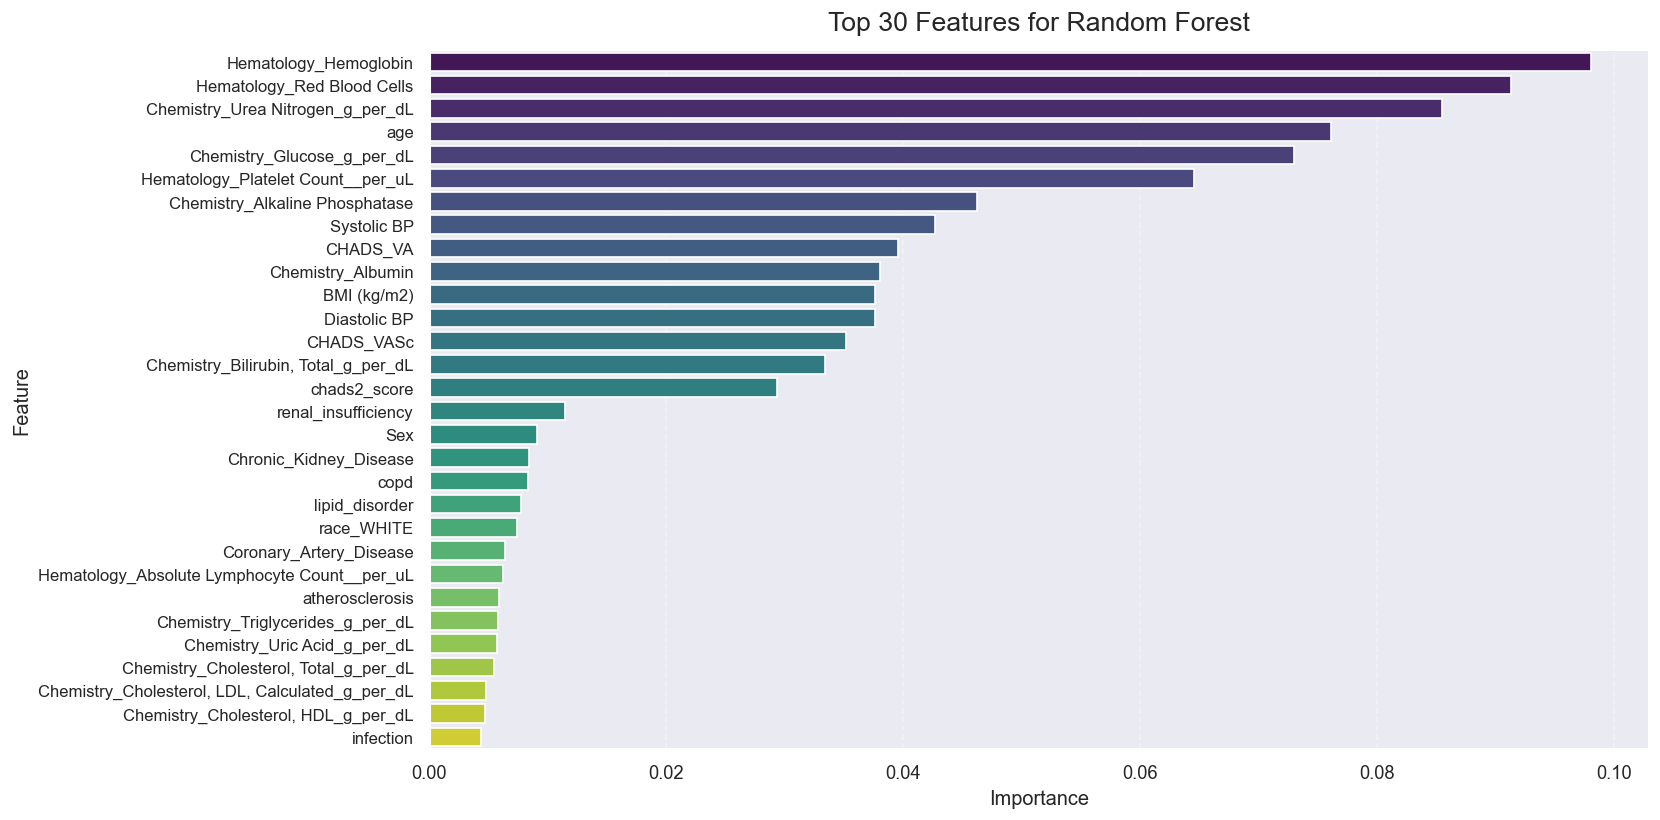

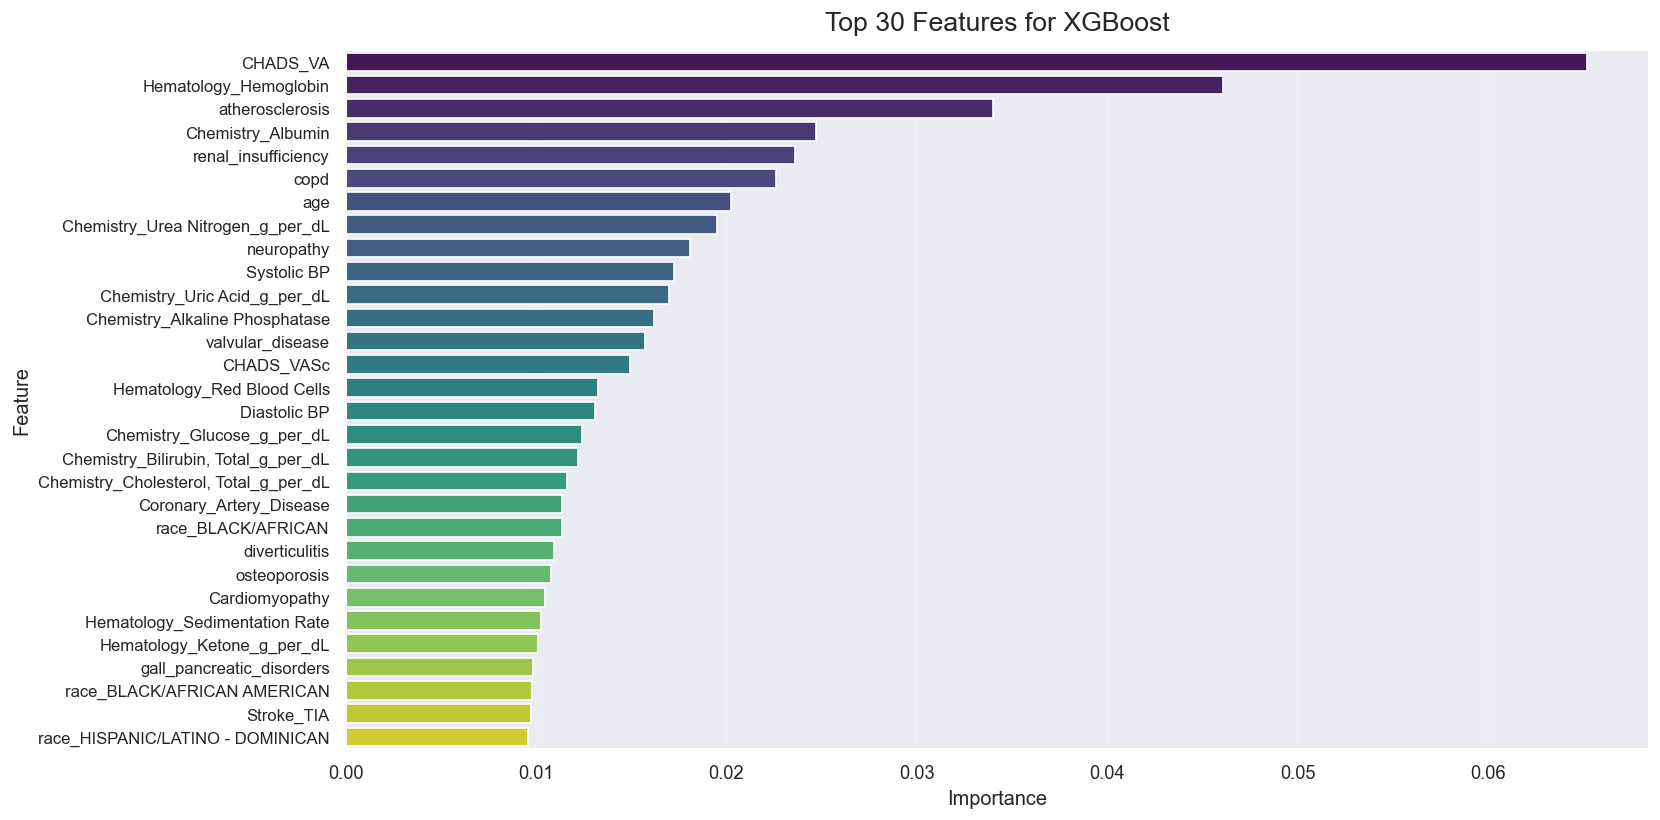

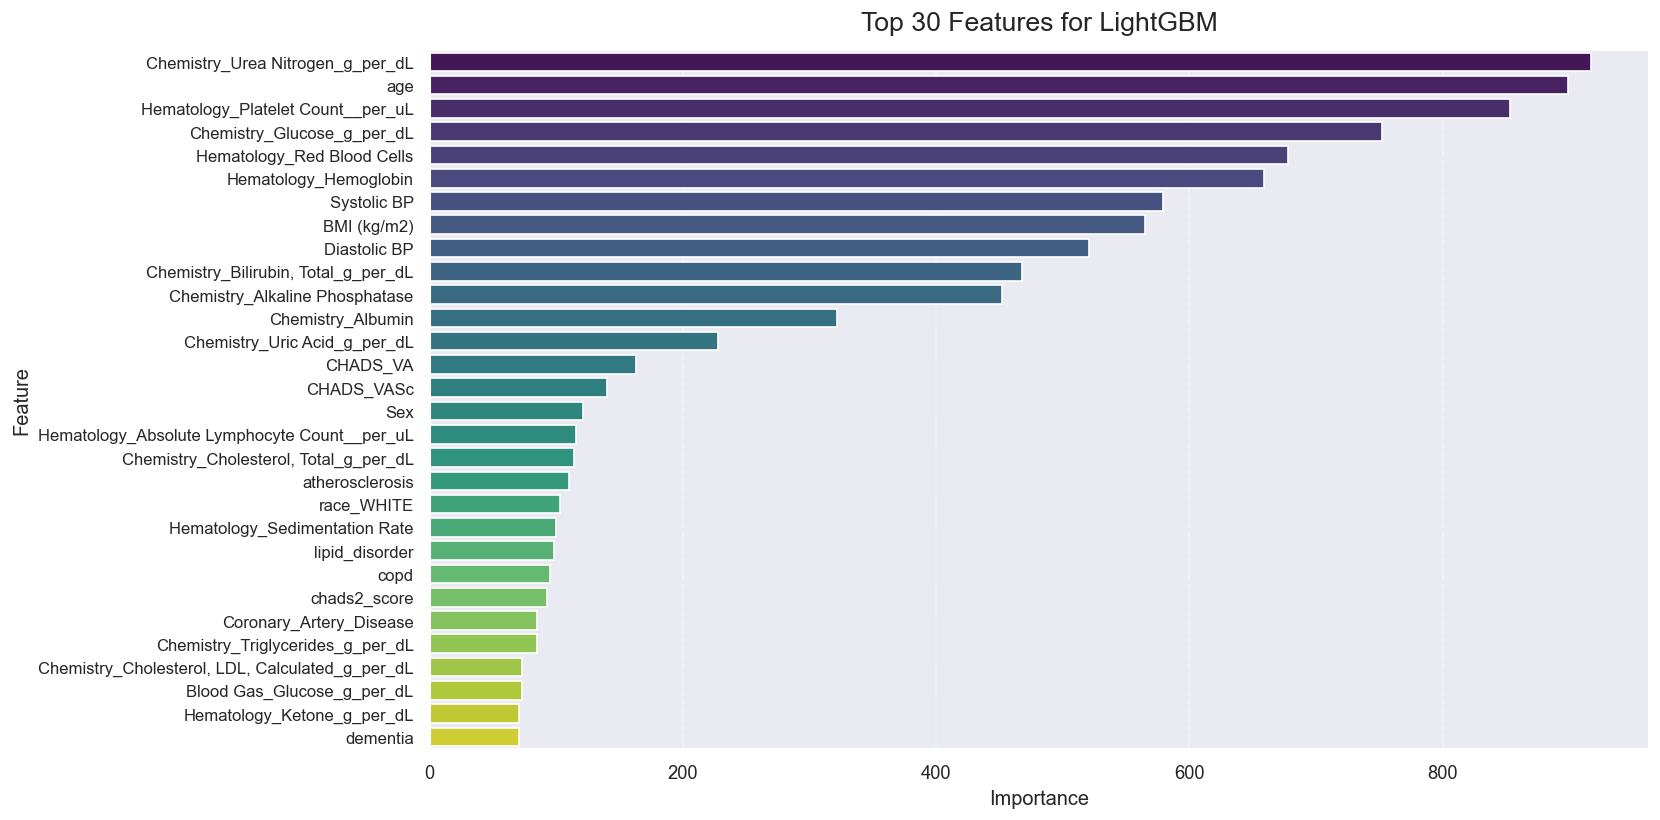

In [ ]:
# ===============================
# Block 9 — Feature importances (TOP 30, most important on top)
# ===============================
import re, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt

def _get_transformed_feature_names(preprocessor):
    try:
        return preprocessor.get_feature_names_out()
    except Exception:
        names = []
        for tname, transformer, cols in preprocessor.transformers_:
            if transformer == 'drop':
                continue
            last = transformer.named_steps[list(transformer.named_steps)[-1]] if hasattr(transformer, 'named_steps') else transformer
            try:
                out = last.get_feature_names_out(cols)
            except Exception:
                out = np.array(cols, dtype=object)
            names.extend([f"{tname}__{c}" for c in out])
        return np.array(names, dtype=object)

def _prettify(names):
    return np.array([re.sub(r'^(num|bin|cat)__', '', n) for n in names], dtype=object)

def _feature_importance_df(pipeline):
    pre  = pipeline.named_steps['preprocessor']
    clf  = pipeline.named_steps['classifier']
    names = _get_transformed_feature_names(pre)
    importances = getattr(clf, 'feature_importances_', None)
    if importances is None:
        return None
    m = min(len(names), len(importances))
    if len(names) != len(importances):
        print(f"[Block 9] Warning: names={len(names)} vs importances={len(importances)} → aligning to {m}.")
    names = _prettify(names[:m])
    imp   = np.asarray(importances[:m], dtype=float)
    return pd.DataFrame({'feature': names, 'importance': imp}).sort_values('importance', ascending=False)

def plot_top_importances(pipeline, model_name, topn=30, save_path=None):  # <- default 30
    df_imp = _feature_importance_df(pipeline)
    if df_imp is None:
        print(f"[Block 9] {model_name} has no feature_importances_. Skipping.")
        return

    topN   = df_imp.head(topn).copy()            # DESC: largest → smallest
    yorder = topN['feature'].tolist()            # we want the first (largest) at the very top

    plt.figure(figsize=(14, 7), dpi=120)
    ax = sns.barplot(x='importance', y='feature', data=topN, order=yorder, palette='viridis')
    ax.set_title(f"Top {min(topn, len(df_imp))} Features for {model_name}", fontsize=16, pad=12)
    ax.set_xlabel("Importance", fontsize=12)
    ax.set_ylabel("Feature", fontsize=12)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(axis='x', linestyle='--', alpha=0.3)

    # Ensure the topmost tick is the most important feature
    expected_top = yorder[0]
    yt_labels = [t.get_text() for t in ax.get_yticklabels()]
    if yt_labels and yt_labels[0] != expected_top:
        ax.invert_yaxis()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=160, bbox_inches='tight')
    plt.show()

# Run for fitted models (skip None)
for name, model in [("Random Forest", best_rf), ("XGBoost", best_xgb), ("LightGBM", best_lgb)]:
    if model is not None:
        plot_top_importances(model, name, topn=30)


In [ ]:
# ===============================
# Block 10 — SHAP summary + dependence grid (TOP 30, with background data)
# What it does:
#   • Uses a small background sample → keeps interventional + probability working
#   • Beeswarm (top 30) + dependence grid (top 30)
#   • Always shows and also saves PNGs
# ===============================
import os, re, warnings
warnings.filterwarnings("ignore", message=".*invalid value encountered in divide.*")

try:
    import shap
except Exception:
    print("[Block 10] SHAP not installed. Run: pip install shap")
else:
    def _transformed_names(preprocessor):
        try:
            return preprocessor.get_feature_names_out()
        except Exception:
            names = []
            for tname, transformer, cols in preprocessor.transformers_:
                if transformer == 'drop':
                    continue
                last = transformer.named_steps[list(transformer.named_steps)[-1]] if hasattr(transformer, 'named_steps') else transformer
                try:
                    out = last.get_feature_names_out(cols)
                except Exception:
                    out = np.array(cols, dtype=object)
                names.extend([f"{tname}__{c}" for c in out])
            return np.array(names, dtype=object)

    def _pretty(names):
        return np.array([re.sub(r'^(num|bin|cat)__', '', n) for n in names], dtype=object)

    def explain_with_shap(pipeline, model_name, X_train,
                          n_sample=2500,          # rows used for plotting
                          bg_size=200,            # background rows for interventional SHAP
                          max_display=30,         # beeswarm top-K
                          dep_topk=30,            # dependence grid top-K
                          n_cols=5,               # 5 cols × 6 rows = 30
                          save_dir="results/shap",
                          dpi=180):
        os.makedirs(save_dir, exist_ok=True)
        safe_name = re.sub(r'\s+', '_', str(model_name))

        pre = pipeline.named_steps['preprocessor']
        clf = pipeline.named_steps['classifier']

        # ---- Sample & transform ----
        sample = X_train.sample(min(n_sample, len(X_train)), random_state=42)
        Xt = pre.transform(sample)
        if hasattr(Xt, "toarray"):  # sparse -> dense
            Xt = Xt.toarray()

        names = _transformed_names(pre)
        m = min(len(names), Xt.shape[1])
        names = names[:m]; Xt = Xt[:, :m]
        pretty = _pretty(names)
        X_df = pd.DataFrame(Xt, columns=pretty)

        # ---- Background set for interventional SHAP ----
        bg = shap.sample(Xt, min(bg_size, Xt.shape[0]), random_state=42)

        # ---- Build explainer (primary: interventional + probability; fallback: generic) ----
        try:
            explainer = shap.TreeExplainer(
                clf,
                data=bg,                           # <- crucial to avoid tree_path_dependent fallback
                feature_perturbation="interventional",
                model_output="probability"
            )
            shap_vals = explainer.shap_values(Xt)
            shap_to_plot = shap_vals[1] if isinstance(shap_vals, list) else shap_vals
        except Exception as e:
            print(f"[Block 10] Falling back to generic SHAP explainer due to: {e}")
            explainer = shap.Explainer(clf, bg)
            sv = explainer(Xt)
            shap_to_plot = sv.values  # may be in log-odds depending on backend

        print(f"[Block 10] {model_name} — SHAP sample: rows={Xt.shape[0]}, features={Xt.shape[1]}")

        # ===== Beeswarm (top 30) =====
        plt.figure(figsize=(9, 6))
        shap.summary_plot(shap_to_plot, Xt, feature_names=pretty,
                          max_display=max_display, plot_type="dot", show=False)
        plt.tight_layout()
        bees_path = os.path.join(save_dir, f"{safe_name}_beeswarm_top{max_display}.png")
        plt.savefig(bees_path, dpi=dpi, bbox_inches="tight"); plt.show()
        print(f"[Block 10] Saved beeswarm → {bees_path}")

        # ===== Dependence grid (TOP 30) =====
        mean_abs = np.abs(shap_to_plot).mean(axis=0)
        top_idx = np.argsort(mean_abs)[-dep_topk:][::-1]
        top_feats = [pretty[i] for i in top_idx]

        n_rows = int(np.ceil(dep_topk / n_cols))
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.2*n_cols, 3.6*n_rows))
        axes = np.atleast_1d(axes).ravel()

        for i, feat in enumerate(top_feats):
            shap.dependence_plot(
                feat, shap_to_plot, X_df,
                interaction_index="auto",
                ax=axes[i], show=False
            )
            axes[i].set_title(feat, fontsize=10)

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        fig.suptitle(f"SHAP Dependence Plots: Top {dep_topk} ({model_name})", y=1.02, fontsize=14)
        dep_path = os.path.join(save_dir, f"{safe_name}_dependence_grid_top{dep_topk}.png")
        plt.savefig(dep_path, dpi=dpi, bbox_inches="tight"); plt.show()
        print(f"[Block 10] Saved dependence grid → {dep_path}")


 99%|===================| 2474/2500 [00:21<00:00]        

[Block 10] XGBoost — SHAP sample: rows=2500, features=145


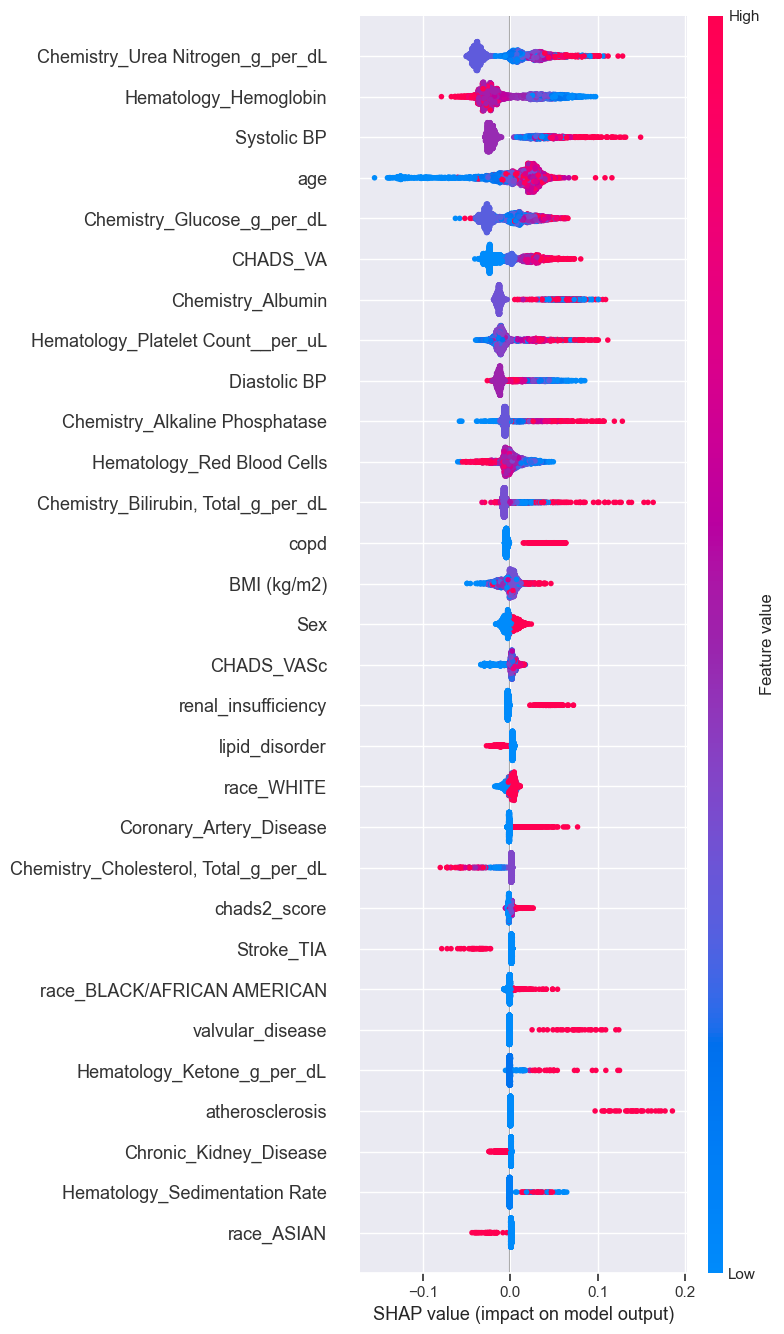

[Block 10] Saved beeswarm → results/shap\XGBoost_beeswarm_top30.png


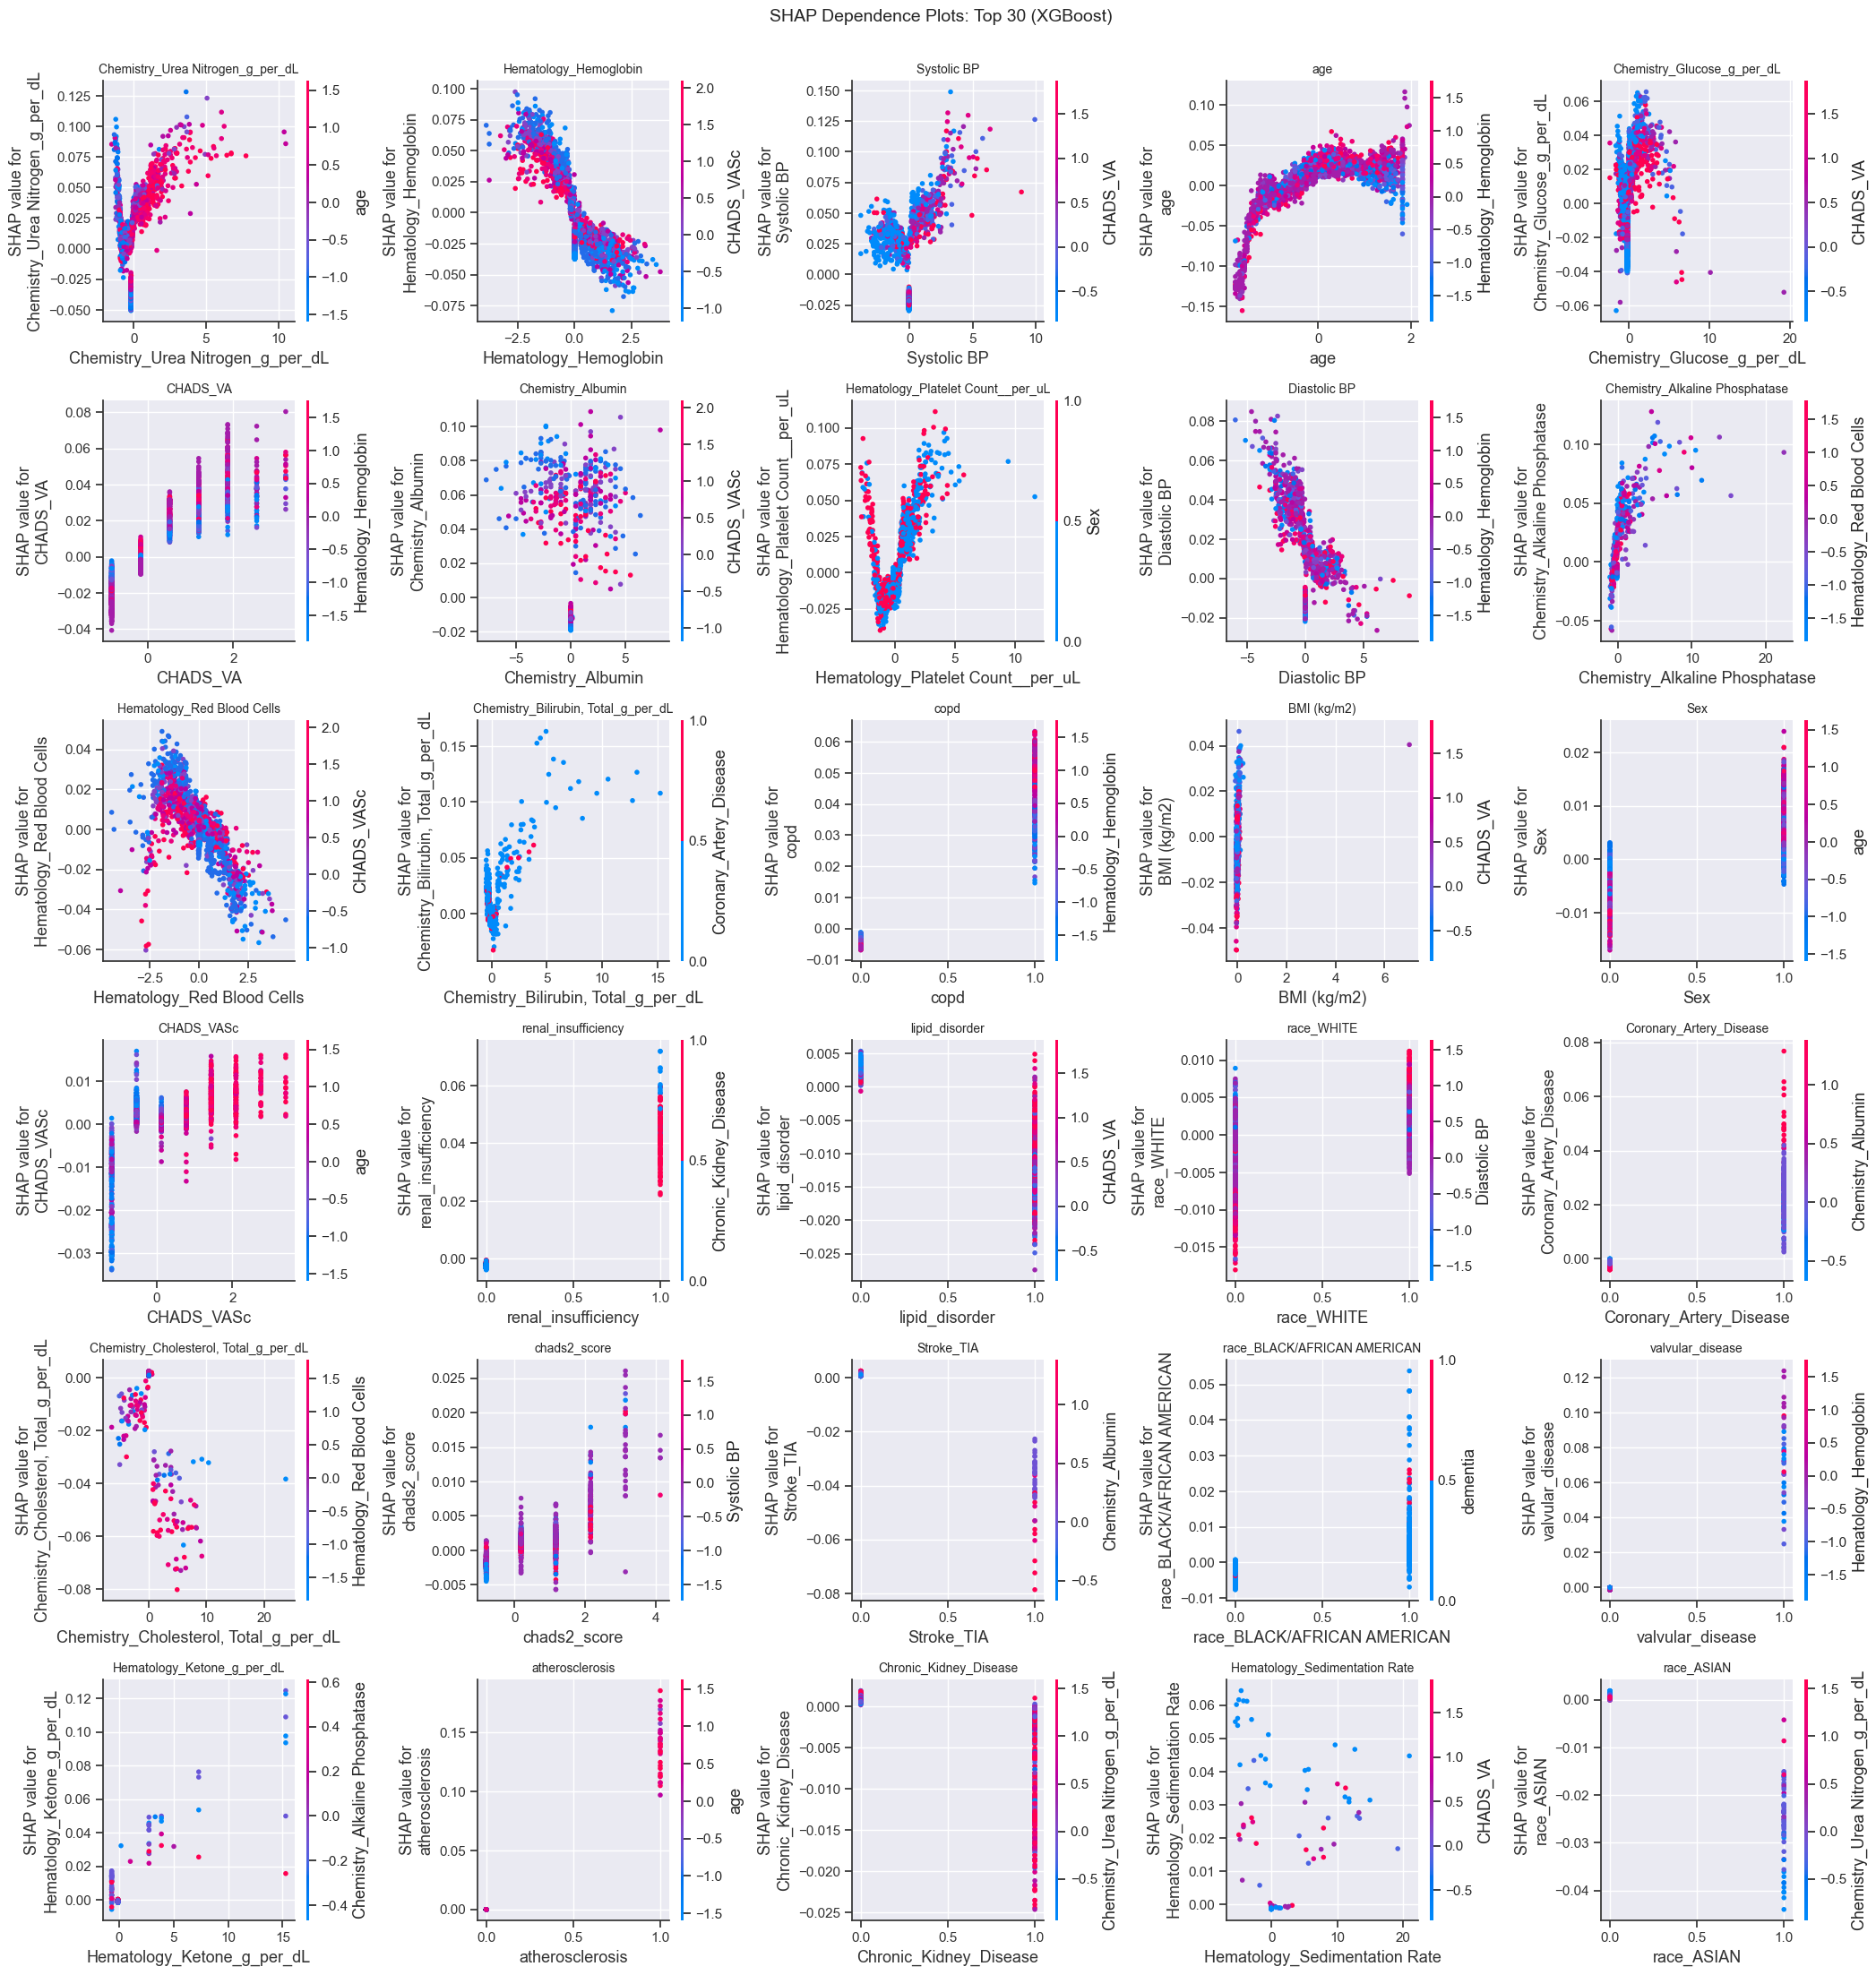

[Block 10] Saved dependence grid → results/shap\XGBoost_dependence_grid_top30.png


In [ ]:
explain_with_shap(best_xgb, "XGBoost", X_train)
# or best_rf / best_lgb


In [ ]:
# ===============================
# Block 11 — Export summary CSV
# ===============================
import pandas as pd

# assumes `results` from Block 8 and `results_df` from 8.A
df_sum = pd.DataFrame(results).copy()
# add chosen thresholds if you set them (e.g., THRESH_XGB in 8.C)
df_sum['thr_used'] = df_sum.apply(
    lambda r: {'XGBoost': globals().get('THRESH_XGB', None),
               'RandomForest': globals().get('THRESH_RF', None),
               'LightGBM': globals().get('THRESH_LGB', None)}.get(r['model'], None),
    axis=1
)
cols = ['model','AUROC_test','AUPRC_test','Brier_test','thr_used']
df_sum[cols].to_csv('readmit_model_summary.csv', index=False)
print("Wrote readmit_model_summary.csv")


Wrote readmit_model_summary.csv
